In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/notebook92c67b5720/submission1.1.csv
/kaggle/input/notebook92c67b5720/submission0.3.csv
/kaggle/input/notebook92c67b5720/submission0.5.csv
/kaggle/input/notebook92c67b5720/submission1.7.csv
/kaggle/input/notebook92c67b5720/submission0.7.csv
/kaggle/input/notebook92c67b5720/__results__.html
/kaggle/input/notebook92c67b5720/submission0.7+ctb.csv
/kaggle/input/notebook92c67b5720/submission1.csv
/kaggle/input/notebook92c67b5720/__notebook_source__.ipynb
/kaggle/input/notebook92c67b5720/submission1.3.csv
/kaggle/input/notebook92c67b5720/__notebook__.ipynb
/kaggle/input/notebook92c67b5720/__output__.json
/kaggle/input/notebook92c67b5720/xgb_lgb_ctb_oof
/kaggle/input/notebook92c67b5720/submission0.3+ctb.csv
/kaggle/input/notebook92c67b5720/custom.css
/kaggle/input/notebook92c67b5720/__results___files/__results___8_1.png
/kaggle/input/notebook92c67b5720/catboost_info/test_error.tsv
/kaggle/input/notebook92c67b5720/catboost_info/learn_error.tsv
/kaggle/input/notebook92c67b5720/cat

In [38]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [49]:
model = MLPRegressor(learning_rate="constant",verbose=True,hidden_layer_sizes=(10,),).fit(train, target)

Iteration 1, loss = 2.52908928
Iteration 2, loss = 0.26237563
Iteration 3, loss = 0.25933047
Iteration 4, loss = 0.25923702
Iteration 5, loss = 0.25924084
Iteration 6, loss = 0.25956200
Iteration 7, loss = 0.25962748
Iteration 8, loss = 0.25919176
Iteration 9, loss = 0.25943444
Iteration 10, loss = 0.25936447
Iteration 11, loss = 0.25962463
Iteration 12, loss = 0.25914112
Iteration 13, loss = 0.25932917
Iteration 14, loss = 0.25915464
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [50]:
mean_squared_error(model.predict(train), target, squared=False)

0.7180712486073944

In [3]:
train = pd.read_csv("/kaggle/input/30-days-of-ml/train.csv", index_col="id")
test  = pd.read_csv("/kaggle/input/30-days-of-ml/test.csv", index_col="id")

target = train["target"]
train = train.drop("target", axis=1)

train_add = pd.read_csv("/kaggle/input/notebook92c67b5720/xgb_lgb_ctb_oof")
train_add["id"] = train.index
train_add = train_add.set_index("id")
test_add  = pd.read_csv("/kaggle/input/notebook92c67b5720/submission1.csv").set_index("id")

train = pd.concat([train, train_add],axis=1)
test  = pd.concat([test , test_add ],axis=1).rename(columns={"target":"oof"})

In [4]:
train["oof"] = 0.5*train["xgb"] + 0.5*train["lgb"]
train = train.drop(["xgb", "lgb", "ctb"], axis=1)

In [5]:
Count_cols   = train.select_dtypes(exclude=['object']).columns
Cat_cols = [ col for col in train.columns if col not in Count_cols ]
print("Number of columns:", len(train.columns))
print("Number of catrgorical columns:", len(Cat_cols))
print("Number of continuous columns:",  len(Count_cols))

ordinalencoder = OrdinalEncoder()

OH_cat_train = pd.DataFrame(ordinalencoder.fit_transform(train[Cat_cols]))
OH_cat_test = pd.DataFrame(ordinalencoder.transform(test[Cat_cols]))

OH_cat_train.index = train.index
OH_cat_test.index = test.index

OH_num_train = train[Count_cols]
OH_num_test = test[Count_cols]

train   = pd.concat([OH_cat_train, OH_num_train], axis=1)
test   = pd.concat([OH_cat_test, OH_num_test], axis=1)

Number of columns: 25
Number of catrgorical columns: 10
Number of continuous columns: 15


# XGB REGRESSOR PARAMTER TUNING OPTUNA

In [12]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(train, target, test_size=0.3, random_state=42)
    param = {
        'objective': 'reg:squarederror', 
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate',
#                                                    [0.008, 0.009, 0.01, 0.]),
        'learning_rate': trial.suggest_float(name="learning_rate", low=0.001, high=0.02, step=0.001),
        'n_estimators': 2000,
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
         'tree_method': "gpu_hist",
    }
    model = xgb.XGBRegressor(**param)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100, verbose=500)
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds, squared=False)
    return rmse

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-08-27 14:44:12,597] A new study created in memory with name: no-name-9c19eda6-c045-4f08-9ce1-5c03a3ce8a2f


[0]	validation_0-rmse:7.75564
[500]	validation_0-rmse:1.86454
[1000]	validation_0-rmse:0.81385
[1500]	validation_0-rmse:0.72276
[1999]	validation_0-rmse:0.71808


[I 2021-08-27 14:44:52,850] Trial 0 finished with value: 0.7180821806427948 and parameters: {'lambda': 0.17440189227791786, 'alpha': 0.12353064447711087, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.003, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 33}. Best is trial 0 with value: 0.7180821806427948.


[0]	validation_0-rmse:7.69395
[500]	validation_0-rmse:0.71764
[758]	validation_0-rmse:0.71712


[I 2021-08-27 14:44:56,881] Trial 1 finished with value: 0.7170662582358531 and parameters: {'lambda': 1.9274201806730027, 'alpha': 3.611852213688631, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.011, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 219}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.64769
[500]	validation_0-rmse:0.71784
[505]	validation_0-rmse:0.71786


[I 2021-08-27 14:45:04,530] Trial 2 finished with value: 0.7175476698840645 and parameters: {'lambda': 4.6762862361349695, 'alpha': 3.47864049724967, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 51}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.67851
[500]	validation_0-rmse:0.71779
[612]	validation_0-rmse:0.71786


[I 2021-08-27 14:45:10,730] Trial 3 finished with value: 0.7177832696203331 and parameters: {'lambda': 0.06001008182011569, 'alpha': 0.03983317464827125, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.013000000000000001, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 127}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.67858
[500]	validation_0-rmse:0.71914
[574]	validation_0-rmse:0.71942


[I 2021-08-27 14:45:44,703] Trial 4 finished with value: 0.7191081894802561 and parameters: {'lambda': 1.5842092697502672, 'alpha': 0.13685953017175206, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.013000000000000001, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 126}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.74020
[500]	validation_0-rmse:0.95464
[1000]	validation_0-rmse:0.71992
[1371]	validation_0-rmse:0.71847


[I 2021-08-27 14:46:16,877] Trial 5 finished with value: 0.7184377092293216 and parameters: {'lambda': 0.10745425114825202, 'alpha': 0.0259969101540035, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.005, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 175}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.67854
[500]	validation_0-rmse:0.71966
[577]	validation_0-rmse:0.71993


[I 2021-08-27 14:47:01,720] Trial 6 finished with value: 0.7196095847737066 and parameters: {'lambda': 0.009124752159681757, 'alpha': 0.016178466725591655, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.013000000000000001, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 74}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.62461
[439]	validation_0-rmse:0.71845


[I 2021-08-27 14:47:10,758] Trial 7 finished with value: 0.7181020448612575 and parameters: {'lambda': 0.1436677154458671, 'alpha': 2.2092548145814126, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 208}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.64765
[470]	validation_0-rmse:0.71837


[I 2021-08-27 14:47:20,440] Trial 8 finished with value: 0.7179992712227571 and parameters: {'lambda': 0.004783392323191554, 'alpha': 2.9769946714518114, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 272}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.72481
[500]	validation_0-rmse:0.75438
[1000]	validation_0-rmse:0.71791
[1019]	validation_0-rmse:0.71792


[I 2021-08-27 14:47:42,775] Trial 9 finished with value: 0.7178714338008217 and parameters: {'lambda': 2.0600300375089473, 'alpha': 0.0764612082765404, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.007, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 245}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.71710
[500]	validation_0-rmse:0.73152
[1000]	validation_0-rmse:0.71740
[1201]	validation_0-rmse:0.71740


[I 2021-08-27 14:47:49,875] Trial 10 finished with value: 0.717387539308466 and parameters: {'lambda': 0.7136611443699223, 'alpha': 0.0013592305758624115, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 293}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.70940
[500]	validation_0-rmse:0.72279
[1000]	validation_0-rmse:0.71740
[1007]	validation_0-rmse:0.71740


[I 2021-08-27 14:47:55,709] Trial 11 finished with value: 0.7173934632344461 and parameters: {'lambda': 0.7775795528454909, 'alpha': 0.001825826517922599, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.009000000000000001, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 296}. Best is trial 1 with value: 0.7170662582358531.


[0]	validation_0-rmse:7.70167
[500]	validation_0-rmse:0.71871
[790]	validation_0-rmse:0.71706


[I 2021-08-27 14:47:59,999] Trial 12 finished with value: 0.7170289331116814 and parameters: {'lambda': 8.201316239661494, 'alpha': 0.0015133502728497245, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.010000000000000002, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 230}. Best is trial 12 with value: 0.7170289331116814.


[0]	validation_0-rmse:7.70167
[500]	validation_0-rmse:0.71935
[734]	validation_0-rmse:0.71798


[I 2021-08-27 14:48:13,541] Trial 13 finished with value: 0.7178323863710314 and parameters: {'lambda': 9.992328101292335, 'alpha': 0.48527937366591306, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.010000000000000002, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 222}. Best is trial 12 with value: 0.7170289331116814.


[0]	validation_0-rmse:7.69400
[500]	validation_0-rmse:0.71915
[1000]	validation_0-rmse:0.71738
[1079]	validation_0-rmse:0.71739


[I 2021-08-27 14:48:19,395] Trial 14 finished with value: 0.717379245241139 and parameters: {'lambda': 9.963552286473941, 'alpha': 0.0053532047904087995, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.011, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 178}. Best is trial 12 with value: 0.7170289331116814.


[0]	validation_0-rmse:7.77106
[500]	validation_0-rmse:4.74758
[1000]	validation_0-rmse:2.93556
[1500]	validation_0-rmse:1.86965
[1999]	validation_0-rmse:1.27022


[I 2021-08-27 14:48:27,244] Trial 15 finished with value: 1.2702219731391535 and parameters: {'lambda': 4.648374399040876, 'alpha': 0.8216103134955843, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 239}. Best is trial 12 with value: 0.7170289331116814.


[0]	validation_0-rmse:7.65539
[500]	validation_0-rmse:0.71700
[550]	validation_0-rmse:0.71705


[I 2021-08-27 14:48:29,953] Trial 16 finished with value: 0.7169354902585375 and parameters: {'lambda': 0.429750069520326, 'alpha': 8.344813244781825, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 191}. Best is trial 16 with value: 0.7169354902585375.


[0]	validation_0-rmse:7.64767
[486]	validation_0-rmse:0.71962


[I 2021-08-27 14:48:46,363] Trial 17 finished with value: 0.719347926367031 and parameters: {'lambda': 0.001090939722977193, 'alpha': 0.006221530780367961, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 180}. Best is trial 16 with value: 0.7169354902585375.


[0]	validation_0-rmse:7.66308
[500]	validation_0-rmse:0.72016
[505]	validation_0-rmse:0.72019


[I 2021-08-27 14:49:16,485] Trial 18 finished with value: 0.7196633292692016 and parameters: {'lambda': 0.03416448296395171, 'alpha': 0.39955356723094965, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 140}. Best is trial 16 with value: 0.7169354902585375.


[0]	validation_0-rmse:7.63224
[421]	validation_0-rmse:0.71876


[I 2021-08-27 14:49:26,965] Trial 19 finished with value: 0.7184827416281696 and parameters: {'lambda': 0.5545143686815869, 'alpha': 0.00476121427888626, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.019000000000000003, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 90}. Best is trial 16 with value: 0.7169354902585375.


[0]	validation_0-rmse:7.73249
[500]	validation_0-rmse:0.81200
[1000]	validation_0-rmse:0.71769
[1170]	validation_0-rmse:0.71769


[I 2021-08-27 14:49:46,264] Trial 20 finished with value: 0.7176264901481381 and parameters: {'lambda': 0.28361798775676994, 'alpha': 6.977978183405941, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 194}. Best is trial 16 with value: 0.7169354902585375.


[0]	validation_0-rmse:7.68624
[500]	validation_0-rmse:0.71709
[666]	validation_0-rmse:0.71698


[I 2021-08-27 14:49:49,629] Trial 21 finished with value: 0.716929197410585 and parameters: {'lambda': 2.7867790360441997, 'alpha': 8.699986093185215, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 255}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.66311
[500]	validation_0-rmse:0.71706
[557]	validation_0-rmse:0.71711


[I 2021-08-27 14:49:52,511] Trial 22 finished with value: 0.7170485717533276 and parameters: {'lambda': 6.646829413755839, 'alpha': 1.1542953661573434, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 272}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.66310
[500]	validation_0-rmse:0.71698
[556]	validation_0-rmse:0.71702


[I 2021-08-27 14:49:55,216] Trial 23 finished with value: 0.7169509639611663 and parameters: {'lambda': 2.6208780303277868, 'alpha': 7.470819334972142, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 257}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.66310
[500]	validation_0-rmse:0.71702
[556]	validation_0-rmse:0.71706


[I 2021-08-27 14:49:58,376] Trial 24 finished with value: 0.7169945605343592 and parameters: {'lambda': 0.36477408370687675, 'alpha': 6.4954204257977075, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 264}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.63225
[449]	validation_0-rmse:0.71753


[I 2021-08-27 14:50:01,971] Trial 25 finished with value: 0.7173302328291582 and parameters: {'lambda': 1.2680860041821613, 'alpha': 1.5063517939493078, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.019000000000000003, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 253}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.67087
[500]	validation_0-rmse:0.71788
[928]	validation_0-rmse:0.71739


[I 2021-08-27 14:50:06,900] Trial 26 finished with value: 0.7173803525965312 and parameters: {'lambda': 2.83107746588382, 'alpha': 8.668148540353242, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014000000000000002, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 299}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.68623
[500]	validation_0-rmse:0.71712
[678]	validation_0-rmse:0.71703


[I 2021-08-27 14:50:10,018] Trial 27 finished with value: 0.716962136149566 and parameters: {'lambda': 1.0642956657040454, 'alpha': 7.701886345226895, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 157}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71701
[529]	validation_0-rmse:0.71705


[I 2021-08-27 14:50:12,657] Trial 28 finished with value: 0.7169362409060981 and parameters: {'lambda': 0.3517077806595622, 'alpha': 9.991352770427941, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 204}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.64771
[474]	validation_0-rmse:0.71816


[I 2021-08-27 14:50:18,853] Trial 29 finished with value: 0.7179712353679215 and parameters: {'lambda': 0.23421750703692143, 'alpha': 0.23363982909780553, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 198}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.63230
[459]	validation_0-rmse:0.71712


[I 2021-08-27 14:50:21,237] Trial 30 finished with value: 0.7169963037516962 and parameters: {'lambda': 0.029123742852138982, 'alpha': 4.7551585976246304, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.019000000000000003, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 12}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71698
[528]	validation_0-rmse:0.71702


[I 2021-08-27 14:50:23,931] Trial 31 finished with value: 0.7169348040260672 and parameters: {'lambda': 0.4457820006107535, 'alpha': 9.741194366007793, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 206}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71699
[530]	validation_0-rmse:0.71703


[I 2021-08-27 14:50:26,423] Trial 32 finished with value: 0.7169303015157245 and parameters: {'lambda': 0.40401658388397776, 'alpha': 9.252201588727644, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 210}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.64001
[497]	validation_0-rmse:0.71725


[I 2021-08-27 14:50:29,547] Trial 33 finished with value: 0.7171152940276094 and parameters: {'lambda': 0.5017963778610987, 'alpha': 1.8977385955142023, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 159}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.68626
[500]	validation_0-rmse:0.71754
[663]	validation_0-rmse:0.71757


[I 2021-08-27 14:50:36,249] Trial 34 finished with value: 0.7174429332365704 and parameters: {'lambda': 0.07051725315652914, 'alpha': 3.868837720392309, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 227}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65542
[500]	validation_0-rmse:0.71738
[511]	validation_0-rmse:0.71739


[I 2021-08-27 14:50:39,795] Trial 35 finished with value: 0.7172247368101 and parameters: {'lambda': 0.14830609401088962, 'alpha': 4.1810242794571995, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 212}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.67082
[500]	validation_0-rmse:0.71793
[542]	validation_0-rmse:0.71811


[I 2021-08-27 14:50:56,060] Trial 36 finished with value: 0.7178256225180781 and parameters: {'lambda': 0.2050879969400586, 'alpha': 9.831427784041807, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014000000000000002, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 185}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.62465
[432]	validation_0-rmse:0.71842


[I 2021-08-27 14:51:04,324] Trial 37 finished with value: 0.7180847761472741 and parameters: {'lambda': 3.958711413621574, 'alpha': 0.8745409911670444, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 111}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.68627
[500]	validation_0-rmse:0.71728
[689]	validation_0-rmse:0.71715


[I 2021-08-27 14:51:08,156] Trial 38 finished with value: 0.7171094547372029 and parameters: {'lambda': 1.062583281250973, 'alpha': 2.194801608932357, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 167}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.67084
[500]	validation_0-rmse:0.71819
[532]	validation_0-rmse:0.71831


[I 2021-08-27 14:51:17,631] Trial 39 finished with value: 0.7180356549273581 and parameters: {'lambda': 0.08664286069626986, 'alpha': 3.0289914121747117, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014000000000000002, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 279}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71779
[622]	validation_0-rmse:0.71788


[I 2021-08-27 14:51:28,680] Trial 40 finished with value: 0.7177701037714687 and parameters: {'lambda': 0.046441862236205944, 'alpha': 4.900856972927485, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 242}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.64002
[474]	validation_0-rmse:0.71703


[I 2021-08-27 14:51:30,940] Trial 41 finished with value: 0.7169379639954128 and parameters: {'lambda': 0.3992087223472453, 'alpha': 9.36763521849503, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 210}. Best is trial 21 with value: 0.716929197410585.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71697
[528]	validation_0-rmse:0.71701


[I 2021-08-27 14:51:33,437] Trial 42 finished with value: 0.7169222942974434 and parameters: {'lambda': 0.1256735304571425, 'alpha': 9.788149594730783, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 197}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.67855
[500]	validation_0-rmse:0.71709
[625]	validation_0-rmse:0.71713


[I 2021-08-27 14:51:36,932] Trial 43 finished with value: 0.7170573155735751 and parameters: {'lambda': 0.15550856717231126, 'alpha': 3.0994635927176377, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.013000000000000001, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 146}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.64002
[500]	validation_0-rmse:0.71718
[557]	validation_0-rmse:0.71722


[I 2021-08-27 14:51:39,942] Trial 44 finished with value: 0.7171563615388248 and parameters: {'lambda': 0.11089003516324648, 'alpha': 5.014201349757891, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 224}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71708
[558]	validation_0-rmse:0.71712


[I 2021-08-27 14:51:42,630] Trial 45 finished with value: 0.7170588489888932 and parameters: {'lambda': 0.021225470494161996, 'alpha': 9.359532690715637, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 188}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.64769
[500]	validation_0-rmse:0.71704
[521]	validation_0-rmse:0.71706


[I 2021-08-27 14:51:45,383] Trial 46 finished with value: 0.7169784031478503 and parameters: {'lambda': 0.8038317502801319, 'alpha': 5.756476528500904, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 234}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.67085
[500]	validation_0-rmse:0.71817
[550]	validation_0-rmse:0.71839


[I 2021-08-27 14:51:56,625] Trial 47 finished with value: 0.7180766891626474 and parameters: {'lambda': 1.6513765109985061, 'alpha': 2.4393965408147102, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014000000000000002, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 216}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.67850
[500]	validation_0-rmse:0.71720
[619]	validation_0-rmse:0.71724


[I 2021-08-27 14:52:00,042] Trial 48 finished with value: 0.7171789963297651 and parameters: {'lambda': 0.7236030980238165, 'alpha': 0.1051453969211236, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.013000000000000001, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 198}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.69392
[500]	validation_0-rmse:0.71845
[700]	validation_0-rmse:0.71819


[I 2021-08-27 14:52:10,355] Trial 49 finished with value: 0.7180429134696631 and parameters: {'lambda': 0.23743090621437604, 'alpha': 0.05345620973289002, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.011, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 169}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.74794
[500]	validation_0-rmse:1.26648
[1000]	validation_0-rmse:0.73247
[1500]	validation_0-rmse:0.71830
[1717]	validation_0-rmse:0.71821


[I 2021-08-27 14:53:35,908] Trial 50 finished with value: 0.7181973529645662 and parameters: {'lambda': 0.5203041525084031, 'alpha': 1.550956438224483, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.004, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 136}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71698
[529]	validation_0-rmse:0.71703


[I 2021-08-27 14:53:38,393] Trial 51 finished with value: 0.7169331115469977 and parameters: {'lambda': 0.29394374322384537, 'alpha': 9.707045183659996, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 200}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.64772
[500]	validation_0-rmse:0.71708
[505]	validation_0-rmse:0.71708


[I 2021-08-27 14:53:40,988] Trial 52 finished with value: 0.7169640810449008 and parameters: {'lambda': 0.11230337615049285, 'alpha': 6.205237586675182, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 174}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.66313
[500]	validation_0-rmse:0.71708
[565]	validation_0-rmse:0.71717


[I 2021-08-27 14:53:43,849] Trial 53 finished with value: 0.7170662435959209 and parameters: {'lambda': 0.3006830983895122, 'alpha': 3.3952899994838015, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 205}. Best is trial 42 with value: 0.7169222942974434.


[0]	validation_0-rmse:7.64005
[483]	validation_0-rmse:0.71699


[I 2021-08-27 14:53:46,195] Trial 54 finished with value: 0.7168726837114189 and parameters: {'lambda': 0.053058615179970535, 'alpha': 9.838397497522731, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 193}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.62463
[416]	validation_0-rmse:0.71851


[I 2021-08-27 14:53:56,260] Trial 55 finished with value: 0.7178801631960151 and parameters: {'lambda': 0.05460660484128347, 'alpha': 5.851540155063975, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 250}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64006
[500]	validation_0-rmse:0.71708
[523]	validation_0-rmse:0.71709


[I 2021-08-27 14:53:58,914] Trial 56 finished with value: 0.717032487774178 and parameters: {'lambda': 0.011957961715745202, 'alpha': 9.993125075527042, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 219}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.71711
[500]	validation_0-rmse:0.73045
[936]	validation_0-rmse:0.71725


[I 2021-08-27 14:54:05,509] Trial 57 finished with value: 0.7172110254005294 and parameters: {'lambda': 0.07396085562207466, 'alpha': 3.9911716085247573, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 287}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.63226
[439]	validation_0-rmse:0.71837


[I 2021-08-27 14:54:12,411] Trial 58 finished with value: 0.7179113937557287 and parameters: {'lambda': 0.018102660843537986, 'alpha': 2.3217964844965304, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.019000000000000003, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 182}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64771
[458]	validation_0-rmse:0.71947


[I 2021-08-27 14:54:26,109] Trial 59 finished with value: 0.7191039425704749 and parameters: {'lambda': 0.03893675943120279, 'alpha': 0.020504371090536943, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 239}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71699
[531]	validation_0-rmse:0.71702


[I 2021-08-27 14:54:29,050] Trial 60 finished with value: 0.7169390266150649 and parameters: {'lambda': 0.1562848016388644, 'alpha': 9.875435849736233, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 263}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66310
[500]	validation_0-rmse:0.71700
[553]	validation_0-rmse:0.71704


[I 2021-08-27 14:54:31,915] Trial 61 finished with value: 0.7169627650728279 and parameters: {'lambda': 0.46580992670805427, 'alpha': 7.1058000945083135, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 194}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65538
[500]	validation_0-rmse:0.71701
[531]	validation_0-rmse:0.71704


[I 2021-08-27 14:54:34,711] Trial 62 finished with value: 0.7169483044446749 and parameters: {'lambda': 0.11179169981413434, 'alpha': 7.065128406743884, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 160}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.63996
[480]	validation_0-rmse:0.71711


[I 2021-08-27 14:54:37,265] Trial 63 finished with value: 0.716996374573209 and parameters: {'lambda': 0.2550092926085316, 'alpha': 5.096772488525076, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 203}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64767
[500]	validation_0-rmse:0.71705
[517]	validation_0-rmse:0.71707


[I 2021-08-27 14:54:39,649] Trial 64 finished with value: 0.7169492673576433 and parameters: {'lambda': 0.19064077248485267, 'alpha': 9.874856412580195, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 184}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.67081
[500]	validation_0-rmse:0.71852
[562]	validation_0-rmse:0.71868


[I 2021-08-27 14:54:52,998] Trial 65 finished with value: 0.7184426049623663 and parameters: {'lambda': 0.6189674165593244, 'alpha': 0.01056827022574231, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014000000000000002, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 230}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.63224
[458]	validation_0-rmse:0.71710


[I 2021-08-27 14:54:55,196] Trial 66 finished with value: 0.716983585552319 and parameters: {'lambda': 0.9680632714924748, 'alpha': 7.576990895407992, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.019000000000000003, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 193}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66315
[500]	validation_0-rmse:0.71753
[864]	validation_0-rmse:0.71729


[I 2021-08-27 14:54:59,864] Trial 67 finished with value: 0.7172792297511351 and parameters: {'lambda': 2.271536008455972, 'alpha': 3.515881685865049, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 212}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.70165
[500]	validation_0-rmse:0.71896
[802]	validation_0-rmse:0.71727


[I 2021-08-27 14:55:04,822] Trial 68 finished with value: 0.7172485356834345 and parameters: {'lambda': 0.004673239911370447, 'alpha': 0.0024703245275624615, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.010000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 173}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.67851
[500]	validation_0-rmse:0.71718
[645]	validation_0-rmse:0.71719


[I 2021-08-27 14:55:08,678] Trial 69 finished with value: 0.7171394556600404 and parameters: {'lambda': 1.4490368968314966, 'alpha': 0.46612397808834277, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.013000000000000001, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 150}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65542
[500]	validation_0-rmse:0.71722
[522]	validation_0-rmse:0.71725


[I 2021-08-27 14:55:11,512] Trial 70 finished with value: 0.7171661766279672 and parameters: {'lambda': 0.32350271828887284, 'alpha': 1.3425517105672187, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 221}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71701
[530]	validation_0-rmse:0.71705


[I 2021-08-27 14:55:14,019] Trial 71 finished with value: 0.7169463507554773 and parameters: {'lambda': 0.34419497432097146, 'alpha': 8.34164729380248, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 202}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64773
[500]	validation_0-rmse:0.71702
[505]	validation_0-rmse:0.71702


[I 2021-08-27 14:55:16,412] Trial 72 finished with value: 0.7169043085387801 and parameters: {'lambda': 0.38848388537739625, 'alpha': 9.85910826947978, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 164}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64002
[475]	validation_0-rmse:0.71707


[I 2021-08-27 14:55:18,944] Trial 73 finished with value: 0.7169644037009311 and parameters: {'lambda': 0.4393496216130577, 'alpha': 5.95455214997169, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 121}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64771
[500]	validation_0-rmse:0.71713
[511]	validation_0-rmse:0.71714


[I 2021-08-27 14:55:21,620] Trial 74 finished with value: 0.7170112136449179 and parameters: {'lambda': 0.18104510612331493, 'alpha': 4.372064387847115, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 189}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.67086
[500]	validation_0-rmse:0.71781
[544]	validation_0-rmse:0.71801


[I 2021-08-27 14:55:36,248] Trial 75 finished with value: 0.7176982517837106 and parameters: {'lambda': 3.3185472922006873, 'alpha': 7.861737703869524, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.014000000000000002, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 162}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66316
[500]	validation_0-rmse:0.71718
[569]	validation_0-rmse:0.71723


[I 2021-08-27 14:55:39,546] Trial 76 finished with value: 0.7171715227003667 and parameters: {'lambda': 0.649011697908575, 'alpha': 0.15902798428041492, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 180}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.77105
[500]	validation_0-rmse:4.74769
[1000]	validation_0-rmse:2.93574
[1500]	validation_0-rmse:1.87004
[1999]	validation_0-rmse:1.27064


[I 2021-08-27 14:55:46,043] Trial 77 finished with value: 1.2706383980829632 and parameters: {'lambda': 0.08212985453722471, 'alpha': 9.522517129335386, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.001, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 169}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.63233
[449]	validation_0-rmse:0.71743


[I 2021-08-27 14:55:49,509] Trial 78 finished with value: 0.7172723084914924 and parameters: {'lambda': 0.06042479389117026, 'alpha': 2.832231480720104, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.019000000000000003, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 209}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.62453
[429]	validation_0-rmse:0.71718


[I 2021-08-27 14:55:51,825] Trial 79 finished with value: 0.7170012748877103 and parameters: {'lambda': 0.13068578811368156, 'alpha': 5.920093800553169, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 142}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64774
[500]	validation_0-rmse:0.71758
[530]	validation_0-rmse:0.71763


[I 2021-08-27 14:55:57,846] Trial 80 finished with value: 0.7175242434373486 and parameters: {'lambda': 0.9190921172837867, 'alpha': 4.371321602989812, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 235}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71699
[529]	validation_0-rmse:0.71703


[I 2021-08-27 14:56:00,321] Trial 81 finished with value: 0.716932354551132 and parameters: {'lambda': 0.3833017120604403, 'alpha': 9.500931593798372, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 199}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71701
[529]	validation_0-rmse:0.71705


[I 2021-08-27 14:56:03,128] Trial 82 finished with value: 0.716948297211435 and parameters: {'lambda': 0.23188513067032213, 'alpha': 7.845471831825381, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 195}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64004
[474]	validation_0-rmse:0.71709


[I 2021-08-27 14:56:05,416] Trial 83 finished with value: 0.7169772104096707 and parameters: {'lambda': 7.113413905689043, 'alpha': 5.435511498820936, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 176}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66315
[500]	validation_0-rmse:0.71700
[558]	validation_0-rmse:0.71708


[I 2021-08-27 14:56:08,162] Trial 84 finished with value: 0.7169913525234577 and parameters: {'lambda': 0.4031284646107836, 'alpha': 7.104134550394021, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 218}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64773
[483]	validation_0-rmse:0.71781


[I 2021-08-27 14:56:17,818] Trial 85 finished with value: 0.7175327809476741 and parameters: {'lambda': 0.2863089094670288, 'alpha': 9.687307810722936, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 155}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65543
[500]	validation_0-rmse:0.71715
[536]	validation_0-rmse:0.71719


[I 2021-08-27 14:56:20,730] Trial 86 finished with value: 0.7170950186490244 and parameters: {'lambda': 0.5974268478924212, 'alpha': 1.838228049788966, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 200}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66314
[500]	validation_0-rmse:0.71781
[520]	validation_0-rmse:0.71786


[I 2021-08-27 14:56:29,702] Trial 87 finished with value: 0.7176042563098413 and parameters: {'lambda': 0.09235961552853962, 'alpha': 9.796345839401022, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.015, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 188}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64002
[498]	validation_0-rmse:0.71716


[I 2021-08-27 14:56:32,252] Trial 88 finished with value: 0.7170487819674782 and parameters: {'lambda': 0.1351488373285736, 'alpha': 4.570964794186001, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.018000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 228}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.64766
[470]	validation_0-rmse:0.71809


[I 2021-08-27 14:56:39,803] Trial 89 finished with value: 0.7177695613009468 and parameters: {'lambda': 0.8142811749931099, 'alpha': 2.8701717874855968, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 250}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.67089
[500]	validation_0-rmse:0.71778
[792]	validation_0-rmse:0.71744


[I 2021-08-27 14:56:44,537] Trial 90 finished with value: 0.7174334145277356 and parameters: {'lambda': 1.261347946705455, 'alpha': 3.5574909549098757, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014000000000000002, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 207}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71701
[530]	validation_0-rmse:0.71705


[I 2021-08-27 14:56:47,389] Trial 91 finished with value: 0.7169484006843662 and parameters: {'lambda': 0.3129562384432631, 'alpha': 8.126610315485964, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 214}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.65544
[500]	validation_0-rmse:0.71704
[531]	validation_0-rmse:0.71708


[I 2021-08-27 14:56:49,970] Trial 92 finished with value: 0.7169700798357376 and parameters: {'lambda': 0.486534908639457, 'alpha': 6.285123236269682, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 190}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66315
[500]	validation_0-rmse:0.71695
[565]	validation_0-rmse:0.71704


[I 2021-08-27 14:56:52,599] Trial 93 finished with value: 0.7169341316005207 and parameters: {'lambda': 0.20981832346491225, 'alpha': 9.81657259127026, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 200}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.66313
[500]	validation_0-rmse:0.71705
[578]	validation_0-rmse:0.71714


[I 2021-08-27 14:56:55,466] Trial 94 finished with value: 0.7170314902454842 and parameters: {'lambda': 0.2053222848860655, 'alpha': 5.142832996106192, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 180}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.67857
[500]	validation_0-rmse:0.71692
[624]	validation_0-rmse:0.71696


[I 2021-08-27 14:56:58,642] Trial 95 finished with value: 0.7168958773190588 and parameters: {'lambda': 0.25391217630699253, 'alpha': 9.65905562518627, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.013000000000000001, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 195}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.69399
[500]	validation_0-rmse:0.71748
[718]	validation_0-rmse:0.71698


[I 2021-08-27 14:57:02,165] Trial 96 finished with value: 0.7169205242044756 and parameters: {'lambda': 0.23968366276569528, 'alpha': 6.4244218683896746, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.011, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 164}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.68628
[500]	validation_0-rmse:0.71710
[674]	validation_0-rmse:0.71702


[I 2021-08-27 14:57:05,494] Trial 97 finished with value: 0.7169464717502734 and parameters: {'lambda': 0.25638265040256397, 'alpha': 6.467217340488268, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 164}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.69395
[500]	validation_0-rmse:0.71742
[735]	validation_0-rmse:0.71697


[I 2021-08-27 14:57:09,239] Trial 98 finished with value: 0.7168901406039554 and parameters: {'lambda': 0.16959212699349457, 'alpha': 9.996882093697954, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.011, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 127}. Best is trial 54 with value: 0.7168726837114189.


[0]	validation_0-rmse:7.70937
[500]	validation_0-rmse:0.72172
[879]	validation_0-rmse:0.71697


[I 2021-08-27 14:57:13,499] Trial 99 finished with value: 0.7169293515390018 and parameters: {'lambda': 0.17585168977413157, 'alpha': 7.4958192955943455, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.009000000000000001, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 133}. Best is trial 54 with value: 0.7168726837114189.


In [18]:
optuna.visualization.plot_slice(study)

In [ ]:
print(f"Best rmse value: {study.best_value}")
study.best_params

In [22]:
xgb_params = {'lambda': 0.053058615179970535,
             'alpha': 9.838397497522731,
             'colsample_bytree': 0.8,
             'subsample': 0.7,
             'learning_rate': 0.018000000000000002,
             'max_depth': 5,
             'random_state': 48,
             'min_child_weight': 193,
             'n_estimators':2000,
             'tree_method': "gpu_hist",
              'objective': 'reg:squarederror', }

# LGM PARAMETER TUNING:

In [25]:
import optuna.integration.lightgbm as lgbo

params = {'objective': 'mean_squared_error',  'metric': 'rmse' } #'objective': 'mean_squared_error',
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)
model = lgbo.train(params,
                   lgb_train,
                   valid_sets=[lgb_valid],
                   verbose_eval=False,
                   num_boost_round=100,
                   early_stopping_rounds=5,) 
model.params

[I 2021-08-27 15:08:57,833] A new study created in memory with name: no-name-f13b9684-831f-470d-8436-67434f88d19e


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717670:   0%|          | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 0.717670:  14%|#4        | 1/7 [00:02<00:14,  2.35s/it][I 2021-08-27 15:09:00,196] Trial 0 finished with value: 0.7176695715915172 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.7176695715915172.


feature_fraction, val_score: 0.717670:  14%|#4        | 1/7 [00:02<00:14,  2.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717631:  14%|#4        | 1/7 [00:04<00:14,  2.35s/it]

feature_fraction, val_score: 0.717631:  29%|##8       | 2/7 [00:04<00:11,  2.28s/it][I 2021-08-27 15:09:02,425] Trial 1 finished with value: 0.7176305769357333 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.7176305769357333.


feature_fraction, val_score: 0.717631:  29%|##8       | 2/7 [00:04<00:11,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717342:  29%|##8       | 2/7 [00:07<00:11,  2.28s/it]

feature_fraction, val_score: 0.717342:  43%|####2     | 3/7 [00:07<00:09,  2.43s/it][I 2021-08-27 15:09:05,034] Trial 2 finished with value: 0.7173417881664893 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.7173417881664893.


feature_fraction, val_score: 0.717342:  43%|####2     | 3/7 [00:07<00:09,  2.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717239:  43%|####2     | 3/7 [00:09<00:09,  2.43s/it]

feature_fraction, val_score: 0.717239:  57%|#####7    | 4/7 [00:09<00:06,  2.25s/it][I 2021-08-27 15:09:07,021] Trial 3 finished with value: 0.7172387175021483 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.7172387175021483.


feature_fraction, val_score: 0.717239:  57%|#####7    | 4/7 [00:09<00:06,  2.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717239:  57%|#####7    | 4/7 [00:11<00:06,  2.25s/it]

feature_fraction, val_score: 0.717239:  71%|#######1  | 5/7 [00:11<00:04,  2.21s/it][I 2021-08-27 15:09:09,159] Trial 4 finished with value: 0.7179358663395361 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.7172387175021483.


feature_fraction, val_score: 0.717239:  71%|#######1  | 5/7 [00:11<00:04,  2.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.717170:  71%|#######1  | 5/7 [00:13<00:04,  2.21s/it]

feature_fraction, val_score: 0.717170:  86%|########5 | 6/7 [00:13<00:02,  2.15s/it][I 2021-08-27 15:09:11,190] Trial 5 finished with value: 0.7171696966111305 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.7171696966111305.


feature_fraction, val_score: 0.717170:  86%|########5 | 6/7 [00:13<00:02,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction, val_score: 0.716933:  86%|########5 | 6/7 [00:15<00:02,  2.15s/it]

feature_fraction, val_score: 0.716933: 100%|##########| 7/7 [00:15<00:00,  2.18s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.716933:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716801:   0%|          | 0/20 [00:02<?, ?it/s]

num_leaves, val_score: 0.716801:   5%|5         | 1/20 [00:02<00:48,  2.54s/it][I 2021-08-27 15:09:15,661] Trial 7 finished with value: 0.7168014456619929 and parameters: {'num_leaves': 18}. Best is trial 7 with value: 0.7168014456619929.


num_leaves, val_score: 0.716801:   5%|5         | 1/20 [00:02<00:48,  2.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716801:   5%|5         | 1/20 [00:04<00:48,  2.54s/it]

num_leaves, val_score: 0.716801:  10%|#         | 2/20 [00:04<00:40,  2.26s/it][I 2021-08-27 15:09:17,730] Trial 8 finished with value: 0.7170256433636015 and parameters: {'num_leaves': 39}. Best is trial 7 with value: 0.7168014456619929.


num_leaves, val_score: 0.716801:  10%|#         | 2/20 [00:04<00:40,  2.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716801:  10%|#         | 2/20 [00:06<00:40,  2.26s/it]

num_leaves, val_score: 0.716801:  15%|#5        | 3/20 [00:06<00:39,  2.31s/it][I 2021-08-27 15:09:20,101] Trial 9 finished with value: 0.7176241612103621 and parameters: {'num_leaves': 174}. Best is trial 7 with value: 0.7168014456619929.


num_leaves, val_score: 0.716801:  15%|#5        | 3/20 [00:06<00:39,  2.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716801:  15%|#5        | 3/20 [00:09<00:39,  2.31s/it]

num_leaves, val_score: 0.716801:  20%|##        | 4/20 [00:09<00:36,  2.29s/it][I 2021-08-27 15:09:22,363] Trial 10 finished with value: 0.7174042346920748 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.7168014456619929.


num_leaves, val_score: 0.716801:  20%|##        | 4/20 [00:09<00:36,  2.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716763:  20%|##        | 4/20 [00:11<00:36,  2.29s/it]

num_leaves, val_score: 0.716763:  25%|##5       | 5/20 [00:11<00:32,  2.15s/it][I 2021-08-27 15:09:24,256] Trial 11 finished with value: 0.7167628297775577 and parameters: {'num_leaves': 13}. Best is trial 11 with value: 0.7167628297775577.


num_leaves, val_score: 0.716763:  25%|##5       | 5/20 [00:11<00:32,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716763:  25%|##5       | 5/20 [00:13<00:32,  2.15s/it]

num_leaves, val_score: 0.716763:  30%|###       | 6/20 [00:13<00:32,  2.32s/it][I 2021-08-27 15:09:26,895] Trial 12 finished with value: 0.7171065030085635 and parameters: {'num_leaves': 59}. Best is trial 11 with value: 0.7167628297775577.


num_leaves, val_score: 0.716763:  30%|###       | 6/20 [00:13<00:32,  2.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716763:  30%|###       | 6/20 [00:17<00:32,  2.32s/it]

num_leaves, val_score: 0.716763:  35%|###5      | 7/20 [00:17<00:34,  2.64s/it][I 2021-08-27 15:09:30,204] Trial 13 finished with value: 0.7175552814583583 and parameters: {'num_leaves': 164}. Best is trial 11 with value: 0.7167628297775577.


num_leaves, val_score: 0.716763:  35%|###5      | 7/20 [00:17<00:34,  2.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716763:  35%|###5      | 7/20 [00:19<00:34,  2.64s/it]

num_leaves, val_score: 0.716763:  40%|####      | 8/20 [00:19<00:29,  2.48s/it][I 2021-08-27 15:09:32,326] Trial 14 finished with value: 0.7170235653884337 and parameters: {'num_leaves': 60}. Best is trial 11 with value: 0.7167628297775577.


num_leaves, val_score: 0.716763:  40%|####      | 8/20 [00:19<00:29,  2.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716641:  40%|####      | 8/20 [00:21<00:29,  2.48s/it]

num_leaves, val_score: 0.716641:  45%|####5     | 9/20 [00:21<00:25,  2.28s/it][I 2021-08-27 15:09:34,187] Trial 15 finished with value: 0.7166408378692047 and parameters: {'num_leaves': 7}. Best is trial 15 with value: 0.7166408378692047.


num_leaves, val_score: 0.716641:  45%|####5     | 9/20 [00:21<00:25,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716641:  45%|####5     | 9/20 [00:23<00:25,  2.28s/it]

num_leaves, val_score: 0.716641:  50%|#####     | 10/20 [00:24<00:24,  2.48s/it][I 2021-08-27 15:09:37,121] Trial 16 finished with value: 0.7176903902170243 and parameters: {'num_leaves': 180}. Best is trial 15 with value: 0.7166408378692047.


num_leaves, val_score: 0.716641:  50%|#####     | 10/20 [00:24<00:24,  2.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716641:  50%|#####     | 10/20 [00:26<00:24,  2.48s/it]

num_leaves, val_score: 0.716641:  55%|#####5    | 11/20 [00:26<00:22,  2.47s/it][I 2021-08-27 15:09:39,549] Trial 17 finished with value: 0.7180701782007808 and parameters: {'num_leaves': 248}. Best is trial 15 with value: 0.7166408378692047.


num_leaves, val_score: 0.716641:  55%|#####5    | 11/20 [00:26<00:22,  2.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  55%|#####5    | 11/20 [00:28<00:22,  2.47s/it]

num_leaves, val_score: 0.716608:  60%|######    | 12/20 [00:28<00:18,  2.28s/it][I 2021-08-27 15:09:41,416] Trial 18 finished with value: 0.716607950167571 and parameters: {'num_leaves': 4}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  60%|######    | 12/20 [00:28<00:18,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  60%|######    | 12/20 [00:30<00:18,  2.28s/it]

num_leaves, val_score: 0.716608:  65%|######5   | 13/20 [00:30<00:15,  2.25s/it][I 2021-08-27 15:09:43,584] Trial 19 finished with value: 0.7172993513653277 and parameters: {'num_leaves': 88}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  65%|######5   | 13/20 [00:30<00:15,  2.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  65%|######5   | 13/20 [00:32<00:15,  2.25s/it]

num_leaves, val_score: 0.716608:  70%|#######   | 14/20 [00:32<00:12,  2.15s/it][I 2021-08-27 15:09:45,493] Trial 20 finished with value: 0.7166204412850584 and parameters: {'num_leaves': 5}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  70%|#######   | 14/20 [00:32<00:12,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  70%|#######   | 14/20 [00:35<00:12,  2.15s/it]

num_leaves, val_score: 0.716608:  75%|#######5  | 15/20 [00:35<00:11,  2.33s/it][I 2021-08-27 15:09:48,236] Trial 21 finished with value: 0.717293574257655 and parameters: {'num_leaves': 92}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  75%|#######5  | 15/20 [00:35<00:11,  2.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  75%|#######5  | 15/20 [00:37<00:11,  2.33s/it]

num_leaves, val_score: 0.716608:  80%|########  | 16/20 [00:37<00:09,  2.37s/it][I 2021-08-27 15:09:50,724] Trial 22 finished with value: 0.7179574221306537 and parameters: {'num_leaves': 250}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  80%|########  | 16/20 [00:37<00:09,  2.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  80%|########  | 16/20 [00:39<00:09,  2.37s/it]

num_leaves, val_score: 0.716608:  85%|########5 | 17/20 [00:39<00:06,  2.25s/it][I 2021-08-27 15:09:52,700] Trial 23 finished with value: 0.717000846042941 and parameters: {'num_leaves': 35}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  85%|########5 | 17/20 [00:39<00:06,  2.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  85%|########5 | 17/20 [00:41<00:06,  2.25s/it]

num_leaves, val_score: 0.716608:  90%|######### | 18/20 [00:41<00:04,  2.13s/it][I 2021-08-27 15:09:54,533] Trial 24 finished with value: 0.7166300194023135 and parameters: {'num_leaves': 6}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  90%|######### | 18/20 [00:41<00:04,  2.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  90%|######### | 18/20 [00:43<00:04,  2.13s/it]

num_leaves, val_score: 0.716608:  95%|#########5| 19/20 [00:43<00:02,  2.13s/it][I 2021-08-27 15:09:56,675] Trial 25 finished with value: 0.7174260168032796 and parameters: {'num_leaves': 95}. Best is trial 18 with value: 0.716607950167571.


num_leaves, val_score: 0.716608:  95%|#########5| 19/20 [00:43<00:02,  2.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




num_leaves, val_score: 0.716608:  95%|#########5| 19/20 [00:46<00:02,  2.13s/it]

num_leaves, val_score: 0.716608: 100%|##########| 20/20 [00:46<00:00,  2.31s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.716608:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716608:   0%|          | 0/10 [00:03<?, ?it/s]

bagging, val_score: 0.716608:  10%|#         | 1/10 [00:03<00:30,  3.38s/it][I 2021-08-27 15:10:02,621] Trial 27 finished with value: 0.7166138974202796 and parameters: {'bagging_fraction': 0.9870259334546275, 'bagging_freq': 4}. Best is trial 27 with value: 0.7166138974202796.


bagging, val_score: 0.716608:  10%|#         | 1/10 [00:03<00:30,  3.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716608:  10%|#         | 1/10 [00:05<00:30,  3.38s/it]

bagging, val_score: 0.716608:  20%|##        | 2/10 [00:05<00:19,  2.49s/it][I 2021-08-27 15:10:04,482] Trial 28 finished with value: 0.7166479729328357 and parameters: {'bagging_fraction': 0.5619587133272682, 'bagging_freq': 2}. Best is trial 27 with value: 0.7166138974202796.


bagging, val_score: 0.716608:  20%|##        | 2/10 [00:05<00:19,  2.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716608:  20%|##        | 2/10 [00:06<00:19,  2.49s/it]

bagging, val_score: 0.716608:  30%|###       | 3/10 [00:06<00:14,  2.04s/it][I 2021-08-27 15:10:05,992] Trial 29 finished with value: 0.7166594406223518 and parameters: {'bagging_fraction': 0.42201378660655847, 'bagging_freq': 6}. Best is trial 27 with value: 0.7166138974202796.


bagging, val_score: 0.716608:  30%|###       | 3/10 [00:06<00:14,  2.04s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  30%|###       | 3/10 [00:08<00:14,  2.04s/it]

bagging, val_score: 0.716592:  40%|####      | 4/10 [00:08<00:11,  1.88s/it][I 2021-08-27 15:10:07,627] Trial 30 finished with value: 0.7165917454995495 and parameters: {'bagging_fraction': 0.5060683501305832, 'bagging_freq': 1}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  40%|####      | 4/10 [00:08<00:11,  1.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  40%|####      | 4/10 [00:11<00:11,  1.88s/it]

bagging, val_score: 0.716592:  50%|#####     | 5/10 [00:11<00:10,  2.17s/it][I 2021-08-27 15:10:10,310] Trial 31 finished with value: 0.7166113075102027 and parameters: {'bagging_fraction': 0.9355939429381613, 'bagging_freq': 1}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  50%|#####     | 5/10 [00:11<00:10,  2.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  50%|#####     | 5/10 [00:12<00:10,  2.17s/it]

bagging, val_score: 0.716592:  60%|######    | 6/10 [00:12<00:08,  2.04s/it][I 2021-08-27 15:10:12,083] Trial 32 finished with value: 0.7166794905618301 and parameters: {'bagging_fraction': 0.5652580971923058, 'bagging_freq': 4}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  60%|######    | 6/10 [00:12<00:08,  2.04s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  60%|######    | 6/10 [00:14<00:08,  2.04s/it]

bagging, val_score: 0.716592:  70%|#######   | 7/10 [00:14<00:05,  1.93s/it][I 2021-08-27 15:10:13,807] Trial 33 finished with value: 0.7166244741629296 and parameters: {'bagging_fraction': 0.5568954338478074, 'bagging_freq': 1}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  70%|#######   | 7/10 [00:14<00:05,  1.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  70%|#######   | 7/10 [00:16<00:05,  1.93s/it]

bagging, val_score: 0.716592:  80%|########  | 8/10 [00:16<00:03,  1.89s/it][I 2021-08-27 15:10:15,603] Trial 34 finished with value: 0.7166284859828842 and parameters: {'bagging_fraction': 0.5664561123586476, 'bagging_freq': 3}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  80%|########  | 8/10 [00:16<00:03,  1.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  80%|########  | 8/10 [00:18<00:03,  1.89s/it]

bagging, val_score: 0.716592:  90%|######### | 9/10 [00:18<00:01,  1.86s/it][I 2021-08-27 15:10:17,384] Trial 35 finished with value: 0.7166433705968144 and parameters: {'bagging_fraction': 0.7120567205677166, 'bagging_freq': 6}. Best is trial 30 with value: 0.7165917454995495.


bagging, val_score: 0.716592:  90%|######### | 9/10 [00:18<00:01,  1.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




bagging, val_score: 0.716592:  90%|######### | 9/10 [00:20<00:01,  1.86s/it]

bagging, val_score: 0.716592: 100%|##########| 10/10 [00:20<00:00,  2.04s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.716592:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction_stage2, val_score: 0.716592:   0%|          | 0/3 [00:02<?, ?it/s]

feature_fraction_stage2, val_score: 0.716592:  33%|###3      | 1/3 [00:02<00:04,  2.09s/it][I 2021-08-27 15:10:21,694] Trial 37 finished with value: 0.7166671617438903 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.7166671617438903.


feature_fraction_stage2, val_score: 0.716592:  33%|###3      | 1/3 [00:02<00:04,  2.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction_stage2, val_score: 0.716592:  33%|###3      | 1/3 [00:03<00:04,  2.09s/it]

feature_fraction_stage2, val_score: 0.716592:  67%|######6   | 2/3 [00:03<00:01,  1.81s/it][I 2021-08-27 15:10:23,307] Trial 38 finished with value: 0.7166921179454483 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.7166671617438903.


feature_fraction_stage2, val_score: 0.716592:  67%|######6   | 2/3 [00:03<00:01,  1.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




feature_fraction_stage2, val_score: 0.716592:  67%|######6   | 2/3 [00:05<00:01,  1.81s/it]

feature_fraction_stage2, val_score: 0.716592: 100%|##########| 3/3 [00:05<00:00,  1.79s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.716592:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:   0%|          | 0/20 [00:01<?, ?it/s]

regularization_factors, val_score: 0.716592:   5%|5         | 1/20 [00:01<00:31,  1.65s/it][I 2021-08-27 15:10:26,631] Trial 40 finished with value: 0.7165917456265087 and parameters: {'lambda_l1': 4.120032814225993e-08, 'lambda_l2': 0.0006476391163608142}. Best is trial 40 with value: 0.7165917456265087.


regularization_factors, val_score: 0.716592:   5%|5         | 1/20 [00:01<00:31,  1.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:   5%|5         | 1/20 [00:03<00:31,  1.65s/it]

regularization_factors, val_score: 0.716592:  10%|#         | 2/20 [00:03<00:29,  1.63s/it][I 2021-08-27 15:10:28,251] Trial 41 finished with value: 0.7165917525313428 and parameters: {'lambda_l1': 0.006544806821603831, 'lambda_l2': 7.448173706909178e-05}. Best is trial 40 with value: 0.7165917456265087.


regularization_factors, val_score: 0.716592:  10%|#         | 2/20 [00:03<00:29,  1.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  10%|#         | 2/20 [00:04<00:29,  1.63s/it]

regularization_factors, val_score: 0.716592:  15%|#5        | 3/20 [00:04<00:27,  1.63s/it][I 2021-08-27 15:10:29,871] Trial 42 finished with value: 0.7165917455160108 and parameters: {'lambda_l1': 1.7393158313605563e-05, 'lambda_l2': 1.2299727705855069e-08}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  15%|#5        | 3/20 [00:04<00:27,  1.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  15%|#5        | 3/20 [00:07<00:27,  1.63s/it]

regularization_factors, val_score: 0.716592:  20%|##        | 4/20 [00:07<00:29,  1.85s/it][I 2021-08-27 15:10:32,052] Trial 43 finished with value: 0.7165917495075934 and parameters: {'lambda_l1': 0.0037363983466773246, 'lambda_l2': 7.624072020595695e-07}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  20%|##        | 4/20 [00:07<00:29,  1.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  20%|##        | 4/20 [00:09<00:29,  1.85s/it]

regularization_factors, val_score: 0.716592:  25%|##5       | 5/20 [00:09<00:32,  2.19s/it][I 2021-08-27 15:10:34,857] Trial 44 finished with value: 0.7165917455199432 and parameters: {'lambda_l1': 2.0697382576419368e-05, 'lambda_l2': 1.9352138071729e-06}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  25%|##5       | 5/20 [00:09<00:32,  2.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  25%|##5       | 5/20 [00:11<00:32,  2.19s/it]

regularization_factors, val_score: 0.716592:  30%|###       | 6/20 [00:11<00:28,  2.00s/it][I 2021-08-27 15:10:36,498] Trial 45 finished with value: 0.7165926922080297 and parameters: {'lambda_l1': 1.362065642929544e-08, 'lambda_l2': 4.768482564608043}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  30%|###       | 6/20 [00:11<00:28,  2.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  30%|###       | 6/20 [00:13<00:28,  2.00s/it]

regularization_factors, val_score: 0.716592:  35%|###5      | 7/20 [00:13<00:24,  1.88s/it][I 2021-08-27 15:10:38,137] Trial 46 finished with value: 0.7165917459327238 and parameters: {'lambda_l1': 0.0004081126929142933, 'lambda_l2': 4.291755483842744e-06}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  35%|###5      | 7/20 [00:13<00:24,  1.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  35%|###5      | 7/20 [00:14<00:24,  1.88s/it]

regularization_factors, val_score: 0.716592:  40%|####      | 8/20 [00:14<00:21,  1.80s/it][I 2021-08-27 15:10:39,768] Trial 47 finished with value: 0.7165918873054348 and parameters: {'lambda_l1': 0.0004465862268582971, 'lambda_l2': 0.7032735256500676}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  40%|####      | 8/20 [00:14<00:21,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  40%|####      | 8/20 [00:16<00:21,  1.80s/it]

regularization_factors, val_score: 0.716592:  45%|####5     | 9/20 [00:16<00:19,  1.75s/it][I 2021-08-27 15:10:41,392] Trial 48 finished with value: 0.7165923048007412 and parameters: {'lambda_l1': 0.5408315581077071, 'lambda_l2': 0.0030159482333254706}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  45%|####5     | 9/20 [00:16<00:19,  1.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  45%|####5     | 9/20 [00:18<00:19,  1.75s/it]

regularization_factors, val_score: 0.716592:  50%|#####     | 10/20 [00:18<00:18,  1.87s/it][I 2021-08-27 15:10:43,530] Trial 49 finished with value: 0.7165917457290737 and parameters: {'lambda_l1': 0.0001221183427494196, 'lambda_l2': 0.0005003565240657926}. Best is trial 42 with value: 0.7165917455160108.


regularization_factors, val_score: 0.716592:  50%|#####     | 10/20 [00:18<00:18,  1.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  50%|#####     | 10/20 [00:20<00:18,  1.87s/it]

regularization_factors, val_score: 0.716592:  55%|#####5    | 11/20 [00:20<00:16,  1.80s/it][I 2021-08-27 15:10:45,165] Trial 50 finished with value: 0.7165917455009495 and parameters: {'lambda_l1': 1.2347436407588586e-06, 'lambda_l2': 1.4914236421406137e-08}. Best is trial 50 with value: 0.7165917455009495.


regularization_factors, val_score: 0.716592:  55%|#####5    | 11/20 [00:20<00:16,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  55%|#####5    | 11/20 [00:21<00:16,  1.80s/it]

regularization_factors, val_score: 0.716592:  60%|######    | 12/20 [00:21<00:13,  1.74s/it][I 2021-08-27 15:10:46,789] Trial 51 finished with value: 0.7165917455009874 and parameters: {'lambda_l1': 1.4155982813217656e-06, 'lambda_l2': 1.7389173353151478e-08}. Best is trial 50 with value: 0.7165917455009495.


regularization_factors, val_score: 0.716592:  60%|######    | 12/20 [00:21<00:13,  1.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  60%|######    | 12/20 [00:23<00:13,  1.74s/it]

regularization_factors, val_score: 0.716592:  65%|######5   | 13/20 [00:23<00:11,  1.71s/it][I 2021-08-27 15:10:48,409] Trial 52 finished with value: 0.7165917454998043 and parameters: {'lambda_l1': 6.367570464575125e-07, 'lambda_l2': 2.2067073078918574e-08}. Best is trial 52 with value: 0.7165917454998043.


regularization_factors, val_score: 0.716592:  65%|######5   | 13/20 [00:23<00:11,  1.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  65%|######5   | 13/20 [00:25<00:11,  1.71s/it]

regularization_factors, val_score: 0.716592:  70%|#######   | 14/20 [00:25<00:10,  1.69s/it][I 2021-08-27 15:10:50,048] Trial 53 finished with value: 0.7165917454997712 and parameters: {'lambda_l1': 3.7991117751633636e-07, 'lambda_l2': 6.228456380834561e-08}. Best is trial 53 with value: 0.7165917454997712.


regularization_factors, val_score: 0.716592:  70%|#######   | 14/20 [00:25<00:10,  1.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  70%|#######   | 14/20 [00:26<00:10,  1.69s/it]

regularization_factors, val_score: 0.716592:  75%|#######5  | 15/20 [00:26<00:08,  1.67s/it][I 2021-08-27 15:10:51,681] Trial 54 finished with value: 0.7165917454995439 and parameters: {'lambda_l1': 1.455975813624415e-07, 'lambda_l2': 5.953965149407594e-07}. Best is trial 54 with value: 0.7165917454995439.


regularization_factors, val_score: 0.716592:  75%|#######5  | 15/20 [00:26<00:08,  1.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  75%|#######5  | 15/20 [00:28<00:08,  1.67s/it]

regularization_factors, val_score: 0.716592:  80%|########  | 16/20 [00:28<00:06,  1.66s/it][I 2021-08-27 15:10:53,305] Trial 55 finished with value: 0.7165917454995554 and parameters: {'lambda_l1': 7.715172347365937e-08, 'lambda_l2': 2.3712127734731228e-07}. Best is trial 54 with value: 0.7165917454995439.


regularization_factors, val_score: 0.716592:  80%|########  | 16/20 [00:28<00:06,  1.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  80%|########  | 16/20 [00:30<00:06,  1.66s/it]

regularization_factors, val_score: 0.716592:  85%|########5 | 17/20 [00:30<00:05,  1.73s/it][I 2021-08-27 15:10:55,196] Trial 56 finished with value: 0.7165917455028776 and parameters: {'lambda_l1': 6.242554846788685e-08, 'lambda_l2': 1.7932739913784695e-05}. Best is trial 54 with value: 0.7165917454995439.


regularization_factors, val_score: 0.716592:  85%|########5 | 17/20 [00:30<00:05,  1.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  85%|########5 | 17/20 [00:31<00:05,  1.73s/it]

regularization_factors, val_score: 0.716592:  90%|######### | 18/20 [00:31<00:03,  1.69s/it][I 2021-08-27 15:10:56,813] Trial 57 finished with value: 0.7165923360741386 and parameters: {'lambda_l1': 0.5717019679479723, 'lambda_l2': 2.40170840868336e-07}. Best is trial 54 with value: 0.7165917454995439.


regularization_factors, val_score: 0.716592:  90%|######### | 18/20 [00:31<00:03,  1.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  90%|######### | 18/20 [00:33<00:03,  1.69s/it]

regularization_factors, val_score: 0.716592:  95%|#########5| 19/20 [00:33<00:01,  1.68s/it][I 2021-08-27 15:10:58,452] Trial 58 finished with value: 0.7166229079381125 and parameters: {'lambda_l1': 9.956270702608876, 'lambda_l2': 0.058075137342665756}. Best is trial 54 with value: 0.7165917454995439.


regularization_factors, val_score: 0.716592:  95%|#########5| 19/20 [00:33<00:01,  1.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




regularization_factors, val_score: 0.716592:  95%|#########5| 19/20 [00:35<00:01,  1.68s/it]

regularization_factors, val_score: 0.716592: 100%|##########| 20/20 [00:35<00:00,  1.76s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.716592:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




min_data_in_leaf, val_score: 0.716592:   0%|          | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 0.716592:  20%|##        | 1/5 [00:01<00:06,  1.61s/it][I 2021-08-27 15:11:01,701] Trial 60 finished with value: 0.7165917454995322 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.7165917454995322.


min_data_in_leaf, val_score: 0.716592:  20%|##        | 1/5 [00:01<00:06,  1.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




min_data_in_leaf, val_score: 0.716592:  20%|##        | 1/5 [00:03<00:06,  1.61s/it]

min_data_in_leaf, val_score: 0.716592:  40%|####      | 2/5 [00:03<00:04,  1.62s/it][I 2021-08-27 15:11:03,324] Trial 61 finished with value: 0.7165947640698269 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.7165917454995322.


min_data_in_leaf, val_score: 0.716592:  40%|####      | 2/5 [00:03<00:04,  1.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




min_data_in_leaf, val_score: 0.716592:  40%|####      | 2/5 [00:05<00:04,  1.62s/it]

min_data_in_leaf, val_score: 0.716592:  60%|######    | 3/5 [00:05<00:03,  1.86s/it][I 2021-08-27 15:11:05,482] Trial 62 finished with value: 0.7165917454995322 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.7165917454995322.


min_data_in_leaf, val_score: 0.716592:  60%|######    | 3/5 [00:05<00:03,  1.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




min_data_in_leaf, val_score: 0.716588:  60%|######    | 3/5 [00:08<00:03,  1.86s/it]

min_data_in_leaf, val_score: 0.716588:  80%|########  | 4/5 [00:08<00:02,  2.24s/it][I 2021-08-27 15:11:08,297] Trial 63 finished with value: 0.7165883755744186 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.7165883755744186.


min_data_in_leaf, val_score: 0.716588:  80%|########  | 4/5 [00:08<00:02,  2.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 8.241546




min_data_in_leaf, val_score: 0.716588:  80%|########  | 4/5 [00:09<00:02,  2.24s/it]

min_data_in_leaf, val_score: 0.716588: 100%|##########| 5/5 [00:09<00:00,  1.98s/it]


{'objective': 'mean_squared_error',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.0283525194011964e-08,
 'lambda_l2': 1.8512656802176627e-07,
 'num_leaves': 4,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.5060683501305832,
 'bagging_freq': 1,
 'min_child_samples': 10,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [28]:
lgb_mse = {'objective': 'mean_squared_error',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.0283525194011964e-08,
 'lambda_l2': 1.8512656802176627e-07,
 'num_leaves': 4,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.5060683501305832,
 'bagging_freq': 1,
 'min_child_samples': 10,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [27]:
import optuna.integration.lightgbm as lgbo

params = {'objective': 'poisson',  'metric': 'rmse' } #'objective': 'mean_squared_error',
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)
model = lgbo.train(params,
                   lgb_train,
                   valid_sets=[lgb_valid],
                   verbose_eval=False,
                   num_boost_round=100,
                   early_stopping_rounds=5,) 
model.params

[I 2021-08-27 15:12:52,573] A new study created in memory with name: no-name-2ab804bc-22c4-4eb8-9ac8-019f540c83aa


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.717076:   0%|          | 0/7 [00:04<?, ?it/s]

feature_fraction, val_score: 0.717076:  14%|#4        | 1/7 [00:04<00:24,  4.10s/it][I 2021-08-27 15:12:56,688] Trial 0 finished with value: 0.7170757368620052 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.7170757368620052.


feature_fraction, val_score: 0.717076:  14%|#4        | 1/7 [00:04<00:24,  4.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  14%|#4        | 1/7 [00:07<00:24,  4.10s/it]

feature_fraction, val_score: 0.716904:  29%|##8       | 2/7 [00:07<00:19,  3.84s/it][I 2021-08-27 15:13:00,343] Trial 1 finished with value: 0.7169037365966624 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.7169037365966624.


feature_fraction, val_score: 0.716904:  29%|##8       | 2/7 [00:07<00:19,  3.84s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  29%|##8       | 2/7 [00:11<00:19,  3.84s/it]

feature_fraction, val_score: 0.716904:  43%|####2     | 3/7 [00:11<00:15,  3.89s/it][I 2021-08-27 15:13:04,282] Trial 2 finished with value: 0.7172856893972873 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.7169037365966624.


feature_fraction, val_score: 0.716904:  43%|####2     | 3/7 [00:11<00:15,  3.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  43%|####2     | 3/7 [00:16<00:15,  3.89s/it]

feature_fraction, val_score: 0.716904:  57%|#####7    | 4/7 [00:16<00:12,  4.07s/it][I 2021-08-27 15:13:08,633] Trial 3 finished with value: 0.7181470642434266 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.7169037365966624.


feature_fraction, val_score: 0.716904:  57%|#####7    | 4/7 [00:16<00:12,  4.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  57%|#####7    | 4/7 [00:19<00:12,  4.07s/it]

feature_fraction, val_score: 0.716904:  71%|#######1  | 5/7 [00:19<00:07,  3.99s/it][I 2021-08-27 15:13:12,470] Trial 4 finished with value: 0.7176599500393289 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.7169037365966624.


feature_fraction, val_score: 0.716904:  71%|#######1  | 5/7 [00:19<00:07,  3.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  71%|#######1  | 5/7 [00:23<00:07,  3.99s/it]

feature_fraction, val_score: 0.716904:  86%|########5 | 6/7 [00:23<00:03,  3.95s/it][I 2021-08-27 15:13:16,339] Trial 5 finished with value: 0.7171903016223775 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.7169037365966624.


feature_fraction, val_score: 0.716904:  86%|########5 | 6/7 [00:23<00:03,  3.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction, val_score: 0.716904:  86%|########5 | 6/7 [00:28<00:03,  3.95s/it]

feature_fraction, val_score: 0.716904: 100%|##########| 7/7 [00:28<00:00,  4.00s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.716904:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:   0%|          | 0/20 [00:04<?, ?it/s]

num_leaves, val_score: 0.716904:   5%|5         | 1/20 [00:04<01:31,  4.79s/it][I 2021-08-27 15:13:25,411] Trial 7 finished with value: 0.7173501607561099 and parameters: {'num_leaves': 142}. Best is trial 7 with value: 0.7173501607561099.


num_leaves, val_score: 0.716904:   5%|5         | 1/20 [00:04<01:31,  4.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:   5%|5         | 1/20 [00:09<01:31,  4.79s/it]

num_leaves, val_score: 0.716904:  10%|#         | 2/20 [00:09<01:29,  4.98s/it][I 2021-08-27 15:13:30,515] Trial 8 finished with value: 0.717641827484113 and parameters: {'num_leaves': 236}. Best is trial 7 with value: 0.7173501607561099.


num_leaves, val_score: 0.716904:  10%|#         | 2/20 [00:09<01:29,  4.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  10%|#         | 2/20 [00:14<01:29,  4.98s/it]

num_leaves, val_score: 0.716904:  15%|#5        | 3/20 [00:14<01:21,  4.79s/it][I 2021-08-27 15:13:35,084] Trial 9 finished with value: 0.7175580993755979 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 0.7173501607561099.


num_leaves, val_score: 0.716904:  15%|#5        | 3/20 [00:14<01:21,  4.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  15%|#5        | 3/20 [00:19<01:21,  4.79s/it]

num_leaves, val_score: 0.716904:  20%|##        | 4/20 [00:19<01:17,  4.87s/it][I 2021-08-27 15:13:40,064] Trial 10 finished with value: 0.7175363154370142 and parameters: {'num_leaves': 217}. Best is trial 7 with value: 0.7173501607561099.


num_leaves, val_score: 0.716904:  20%|##        | 4/20 [00:19<01:17,  4.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  20%|##        | 4/20 [00:23<01:17,  4.87s/it]

num_leaves, val_score: 0.716904:  25%|##5       | 5/20 [00:23<01:06,  4.41s/it][I 2021-08-27 15:13:43,664] Trial 11 finished with value: 0.7169037365966624 and parameters: {'num_leaves': 31}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  25%|##5       | 5/20 [00:23<01:06,  4.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  25%|##5       | 5/20 [00:27<01:06,  4.41s/it]

num_leaves, val_score: 0.716904:  30%|###       | 6/20 [00:27<01:00,  4.30s/it][I 2021-08-27 15:13:47,740] Trial 12 finished with value: 0.7173500536996991 and parameters: {'num_leaves': 137}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  30%|###       | 6/20 [00:27<01:00,  4.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  30%|###       | 6/20 [00:31<01:00,  4.30s/it]

num_leaves, val_score: 0.716904:  35%|###5      | 7/20 [00:31<00:56,  4.37s/it][I 2021-08-27 15:13:52,251] Trial 13 finished with value: 0.7175849966170244 and parameters: {'num_leaves': 183}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  35%|###5      | 7/20 [00:31<00:56,  4.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  35%|###5      | 7/20 [00:36<00:56,  4.37s/it]

num_leaves, val_score: 0.716904:  40%|####      | 8/20 [00:36<00:55,  4.59s/it][I 2021-08-27 15:13:57,332] Trial 14 finished with value: 0.7171371530049259 and parameters: {'num_leaves': 80}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  40%|####      | 8/20 [00:36<00:55,  4.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  40%|####      | 8/20 [00:41<00:55,  4.59s/it]

num_leaves, val_score: 0.716904:  45%|####5     | 9/20 [00:41<00:49,  4.54s/it][I 2021-08-27 15:14:01,765] Trial 15 finished with value: 0.7171417076879293 and parameters: {'num_leaves': 70}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  45%|####5     | 9/20 [00:41<00:49,  4.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  45%|####5     | 9/20 [00:44<00:49,  4.54s/it]

num_leaves, val_score: 0.716904:  50%|#####     | 10/20 [00:44<00:42,  4.29s/it][I 2021-08-27 15:14:05,480] Trial 16 finished with value: 0.7171791885052483 and parameters: {'num_leaves': 84}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  50%|#####     | 10/20 [00:44<00:42,  4.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716904:  50%|#####     | 10/20 [00:47<00:42,  4.29s/it]

num_leaves, val_score: 0.716904:  55%|#####5    | 11/20 [00:47<00:34,  3.85s/it][I 2021-08-27 15:14:08,355] Trial 17 finished with value: 0.7170595993021648 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.7169037365966624.


num_leaves, val_score: 0.716904:  55%|#####5    | 11/20 [00:47<00:34,  3.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  55%|#####5    | 11/20 [00:51<00:34,  3.85s/it]

num_leaves, val_score: 0.716830:  60%|######    | 12/20 [00:51<00:31,  3.90s/it][I 2021-08-27 15:14:12,353] Trial 18 finished with value: 0.7168298017940549 and parameters: {'num_leaves': 19}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  60%|######    | 12/20 [00:51<00:31,  3.90s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  60%|######    | 12/20 [00:55<00:31,  3.90s/it]

num_leaves, val_score: 0.716830:  65%|######5   | 13/20 [00:55<00:26,  3.84s/it][I 2021-08-27 15:14:16,064] Trial 19 finished with value: 0.7168337668304862 and parameters: {'num_leaves': 20}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  65%|######5   | 13/20 [00:55<00:26,  3.84s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  65%|######5   | 13/20 [00:58<00:26,  3.84s/it]

num_leaves, val_score: 0.716830:  70%|#######   | 14/20 [00:58<00:21,  3.60s/it][I 2021-08-27 15:14:19,110] Trial 20 finished with value: 0.7170595993021648 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  70%|#######   | 14/20 [00:58<00:21,  3.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  70%|#######   | 14/20 [01:02<00:21,  3.60s/it]

num_leaves, val_score: 0.716830:  75%|#######5  | 15/20 [01:02<00:18,  3.73s/it][I 2021-08-27 15:14:23,135] Trial 21 finished with value: 0.7169775603718569 and parameters: {'num_leaves': 40}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  75%|#######5  | 15/20 [01:02<00:18,  3.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  75%|#######5  | 15/20 [01:06<00:18,  3.73s/it]

num_leaves, val_score: 0.716830:  80%|########  | 16/20 [01:06<00:14,  3.73s/it][I 2021-08-27 15:14:26,864] Trial 22 finished with value: 0.7169115278054217 and parameters: {'num_leaves': 39}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  80%|########  | 16/20 [01:06<00:14,  3.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  80%|########  | 16/20 [01:10<00:14,  3.73s/it]

num_leaves, val_score: 0.716830:  85%|########5 | 17/20 [01:10<00:11,  3.78s/it][I 2021-08-27 15:14:30,766] Trial 23 finished with value: 0.7170595993021648 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  85%|########5 | 17/20 [01:10<00:11,  3.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  85%|########5 | 17/20 [01:14<00:11,  3.78s/it]

num_leaves, val_score: 0.716830:  90%|######### | 18/20 [01:14<00:08,  4.03s/it][I 2021-08-27 15:14:35,370] Trial 24 finished with value: 0.717185612268449 and parameters: {'num_leaves': 108}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  90%|######### | 18/20 [01:14<00:08,  4.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  90%|######### | 18/20 [01:18<00:08,  4.03s/it]

num_leaves, val_score: 0.716830:  95%|#########5| 19/20 [01:18<00:03,  3.96s/it][I 2021-08-27 15:14:39,177] Trial 25 finished with value: 0.7170537087094561 and parameters: {'num_leaves': 55}. Best is trial 18 with value: 0.7168298017940549.


num_leaves, val_score: 0.716830:  95%|#########5| 19/20 [01:18<00:03,  3.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




num_leaves, val_score: 0.716830:  95%|#########5| 19/20 [01:22<00:03,  3.96s/it]

num_leaves, val_score: 0.716830: 100%|##########| 20/20 [01:22<00:00,  4.14s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.716830:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716830:   0%|          | 0/10 [00:04<?, ?it/s]

bagging, val_score: 0.716830:  10%|#         | 1/10 [00:04<00:42,  4.77s/it][I 2021-08-27 15:14:48,171] Trial 27 finished with value: 0.7168301126071397 and parameters: {'bagging_fraction': 0.9922098103233806, 'bagging_freq': 2}. Best is trial 27 with value: 0.7168301126071397.


bagging, val_score: 0.716830:  10%|#         | 1/10 [00:04<00:42,  4.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716830:  10%|#         | 1/10 [00:07<00:42,  4.77s/it]

bagging, val_score: 0.716830:  20%|##        | 2/10 [00:07<00:29,  3.74s/it][I 2021-08-27 15:14:51,181] Trial 28 finished with value: 0.716857359671407 and parameters: {'bagging_fraction': 0.4276979478735062, 'bagging_freq': 2}. Best is trial 27 with value: 0.7168301126071397.


bagging, val_score: 0.716830:  20%|##        | 2/10 [00:07<00:29,  3.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716830:  20%|##        | 2/10 [00:10<00:29,  3.74s/it]

bagging, val_score: 0.716830:  30%|###       | 3/10 [00:10<00:23,  3.39s/it][I 2021-08-27 15:14:54,160] Trial 29 finished with value: 0.7168792828510364 and parameters: {'bagging_fraction': 0.44700855687789437, 'bagging_freq': 4}. Best is trial 27 with value: 0.7168301126071397.


bagging, val_score: 0.716830:  30%|###       | 3/10 [00:10<00:23,  3.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716789:  30%|###       | 3/10 [00:14<00:23,  3.39s/it]

bagging, val_score: 0.716789:  40%|####      | 4/10 [00:14<00:22,  3.70s/it][I 2021-08-27 15:14:58,333] Trial 30 finished with value: 0.7167886516168243 and parameters: {'bagging_fraction': 0.6736804234533011, 'bagging_freq': 2}. Best is trial 30 with value: 0.7167886516168243.


bagging, val_score: 0.716789:  40%|####      | 4/10 [00:14<00:22,  3.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716773:  40%|####      | 4/10 [00:19<00:22,  3.70s/it]

bagging, val_score: 0.716773:  50%|#####     | 5/10 [00:19<00:20,  4.08s/it][I 2021-08-27 15:15:03,096] Trial 31 finished with value: 0.7167734888844257 and parameters: {'bagging_fraction': 0.6358525529874637, 'bagging_freq': 3}. Best is trial 31 with value: 0.7167734888844257.


bagging, val_score: 0.716773:  50%|#####     | 5/10 [00:19<00:20,  4.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716773:  50%|#####     | 5/10 [00:24<00:20,  4.08s/it]

bagging, val_score: 0.716773:  60%|######    | 6/10 [00:24<00:17,  4.30s/it][I 2021-08-27 15:15:07,822] Trial 32 finished with value: 0.716843045139802 and parameters: {'bagging_fraction': 0.9693939217411934, 'bagging_freq': 2}. Best is trial 31 with value: 0.7167734888844257.


bagging, val_score: 0.716773:  60%|######    | 6/10 [00:24<00:17,  4.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716773:  60%|######    | 6/10 [00:28<00:17,  4.30s/it]

bagging, val_score: 0.716773:  70%|#######   | 7/10 [00:28<00:12,  4.08s/it][I 2021-08-27 15:15:11,439] Trial 33 finished with value: 0.71683404485768 and parameters: {'bagging_fraction': 0.7873074352472832, 'bagging_freq': 3}. Best is trial 31 with value: 0.7167734888844257.


bagging, val_score: 0.716773:  70%|#######   | 7/10 [00:28<00:12,  4.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716773:  70%|#######   | 7/10 [00:32<00:12,  4.08s/it]

bagging, val_score: 0.716773:  80%|########  | 8/10 [00:32<00:08,  4.11s/it][I 2021-08-27 15:15:15,616] Trial 34 finished with value: 0.7168066627244302 and parameters: {'bagging_fraction': 0.8739438874086561, 'bagging_freq': 2}. Best is trial 31 with value: 0.7167734888844257.


bagging, val_score: 0.716773:  80%|########  | 8/10 [00:32<00:08,  4.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716751:  80%|########  | 8/10 [00:36<00:08,  4.11s/it]

bagging, val_score: 0.716751:  90%|######### | 9/10 [00:36<00:04,  4.19s/it][I 2021-08-27 15:15:19,998] Trial 35 finished with value: 0.7167507114528656 and parameters: {'bagging_fraction': 0.7378569421138057, 'bagging_freq': 3}. Best is trial 35 with value: 0.7167507114528656.


bagging, val_score: 0.716751:  90%|######### | 9/10 [00:36<00:04,  4.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




bagging, val_score: 0.716751:  90%|######### | 9/10 [00:39<00:04,  4.19s/it]

bagging, val_score: 0.716751: 100%|##########| 10/10 [00:39<00:00,  3.97s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.716751:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction_stage2, val_score: 0.716751:   0%|          | 0/3 [00:03<?, ?it/s]

feature_fraction_stage2, val_score: 0.716751:  33%|###3      | 1/3 [00:03<00:07,  3.87s/it][I 2021-08-27 15:15:27,010] Trial 37 finished with value: 0.7167507114528656 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.7167507114528656.


feature_fraction_stage2, val_score: 0.716751:  33%|###3      | 1/3 [00:03<00:07,  3.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction_stage2, val_score: 0.716751:  33%|###3      | 1/3 [00:08<00:07,  3.87s/it]

feature_fraction_stage2, val_score: 0.716751:  67%|######6   | 2/3 [00:08<00:04,  4.15s/it][I 2021-08-27 15:15:31,350] Trial 38 finished with value: 0.7168690713399186 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.7167507114528656.


feature_fraction_stage2, val_score: 0.716751:  67%|######6   | 2/3 [00:08<00:04,  4.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




feature_fraction_stage2, val_score: 0.716751:  67%|######6   | 2/3 [00:13<00:04,  4.15s/it]

feature_fraction_stage2, val_score: 0.716751: 100%|##########| 3/3 [00:13<00:00,  4.42s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.716751:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716751:   0%|          | 0/20 [00:04<?, ?it/s]

regularization_factors, val_score: 0.716751:   5%|5         | 1/20 [00:04<01:23,  4.42s/it][I 2021-08-27 15:15:40,815] Trial 40 finished with value: 0.7167507114440698 and parameters: {'lambda_l1': 3.045940633746094e-06, 'lambda_l2': 5.236529335228821e-08}. Best is trial 40 with value: 0.7167507114440698.


regularization_factors, val_score: 0.716751:   5%|5         | 1/20 [00:04<01:23,  4.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716751:   5%|5         | 1/20 [00:08<01:23,  4.42s/it]

regularization_factors, val_score: 0.716751:  10%|#         | 2/20 [00:08<01:13,  4.11s/it][I 2021-08-27 15:15:44,706] Trial 41 finished with value: 0.7167507114420706 and parameters: {'lambda_l1': 3.7398914086979498e-06, 'lambda_l2': 2.930740160095561e-08}. Best is trial 41 with value: 0.7167507114420706.


regularization_factors, val_score: 0.716751:  10%|#         | 2/20 [00:08<01:13,  4.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716748:  10%|#         | 2/20 [00:12<01:13,  4.11s/it]

regularization_factors, val_score: 0.716748:  15%|#5        | 3/20 [00:12<01:07,  3.98s/it][I 2021-08-27 15:15:48,535] Trial 42 finished with value: 0.7167478500074856 and parameters: {'lambda_l1': 0.08913795237976954, 'lambda_l2': 3.412272144126904e-08}. Best is trial 42 with value: 0.7167478500074856.


regularization_factors, val_score: 0.716748:  15%|#5        | 3/20 [00:12<01:07,  3.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716748:  15%|#5        | 3/20 [00:16<01:07,  3.98s/it]

regularization_factors, val_score: 0.716748:  20%|##        | 4/20 [00:16<01:06,  4.18s/it][I 2021-08-27 15:15:53,016] Trial 43 finished with value: 0.7167965387931461 and parameters: {'lambda_l1': 5.216883318609806, 'lambda_l2': 1.5712221536729985e-05}. Best is trial 42 with value: 0.7167478500074856.


regularization_factors, val_score: 0.716748:  20%|##        | 4/20 [00:16<01:06,  4.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716748:  20%|##        | 4/20 [00:20<01:06,  4.18s/it]

regularization_factors, val_score: 0.716748:  25%|##5       | 5/20 [00:20<01:01,  4.07s/it][I 2021-08-27 15:15:56,887] Trial 44 finished with value: 0.7167738707220798 and parameters: {'lambda_l1': 0.18640212305991144, 'lambda_l2': 1.9974208891819971}. Best is trial 42 with value: 0.7167478500074856.


regularization_factors, val_score: 0.716748:  25%|##5       | 5/20 [00:20<01:01,  4.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716748:  25%|##5       | 5/20 [00:24<01:01,  4.07s/it]

regularization_factors, val_score: 0.716748:  30%|###       | 6/20 [00:24<00:56,  4.01s/it][I 2021-08-27 15:16:00,799] Trial 45 finished with value: 0.716750711451813 and parameters: {'lambda_l1': 3.769150407794047e-07, 'lambda_l2': 3.6414806544008297e-08}. Best is trial 42 with value: 0.7167478500074856.


regularization_factors, val_score: 0.716748:  30%|###       | 6/20 [00:24<00:56,  4.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  30%|###       | 6/20 [00:28<00:56,  4.01s/it]

regularization_factors, val_score: 0.716736:  35%|###5      | 7/20 [00:28<00:53,  4.12s/it][I 2021-08-27 15:16:05,145] Trial 46 finished with value: 0.7167356264061628 and parameters: {'lambda_l1': 0.05564514562079191, 'lambda_l2': 4.823603180983804}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  35%|###5      | 7/20 [00:28<00:53,  4.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  35%|###5      | 7/20 [00:33<00:53,  4.12s/it]

regularization_factors, val_score: 0.716736:  40%|####      | 8/20 [00:33<00:53,  4.44s/it][I 2021-08-27 15:16:10,274] Trial 47 finished with value: 0.7167635884467066 and parameters: {'lambda_l1': 0.01267094003469544, 'lambda_l2': 2.7857876825578656e-07}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  40%|####      | 8/20 [00:33<00:53,  4.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  40%|####      | 8/20 [00:38<00:53,  4.44s/it]

regularization_factors, val_score: 0.716736:  45%|####5     | 9/20 [00:38<00:48,  4.45s/it][I 2021-08-27 15:16:14,744] Trial 48 finished with value: 0.7167507105521121 and parameters: {'lambda_l1': 0.0003238429854681761, 'lambda_l2': 6.746600411490702e-05}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  45%|####5     | 9/20 [00:38<00:48,  4.45s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  45%|####5     | 9/20 [00:42<00:48,  4.45s/it]

regularization_factors, val_score: 0.716736:  50%|#####     | 10/20 [00:42<00:42,  4.27s/it][I 2021-08-27 15:16:18,608] Trial 49 finished with value: 0.716775651153862 and parameters: {'lambda_l1': 0.17014409521473742, 'lambda_l2': 0.2938073273585879}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  50%|#####     | 10/20 [00:42<00:42,  4.27s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  50%|#####     | 10/20 [00:46<00:42,  4.27s/it]

regularization_factors, val_score: 0.716736:  55%|#####5    | 11/20 [00:46<00:37,  4.16s/it][I 2021-08-27 15:16:22,506] Trial 50 finished with value: 0.7167507084585767 and parameters: {'lambda_l1': 0.000632046514867826, 'lambda_l2': 0.02429808993934307}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  55%|#####5    | 11/20 [00:46<00:37,  4.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  55%|#####5    | 11/20 [00:50<00:37,  4.16s/it]

regularization_factors, val_score: 0.716736:  60%|######    | 12/20 [00:50<00:34,  4.28s/it][I 2021-08-27 15:16:27,063] Trial 51 finished with value: 0.7167736309123006 and parameters: {'lambda_l1': 3.086857988486853, 'lambda_l2': 0.004455381003138166}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  60%|######    | 12/20 [00:50<00:34,  4.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  60%|######    | 12/20 [00:54<00:34,  4.28s/it]

regularization_factors, val_score: 0.716736:  65%|######5   | 13/20 [00:54<00:29,  4.18s/it][I 2021-08-27 15:16:31,024] Trial 52 finished with value: 0.7167635913068436 and parameters: {'lambda_l1': 0.01175299986123098, 'lambda_l2': 3.1252971573954942e-06}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  65%|######5   | 13/20 [00:54<00:29,  4.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  65%|######5   | 13/20 [00:59<00:29,  4.18s/it]

regularization_factors, val_score: 0.716736:  70%|#######   | 14/20 [00:59<00:25,  4.28s/it][I 2021-08-27 15:16:35,536] Trial 53 finished with value: 0.7167515167991553 and parameters: {'lambda_l1': 0.1003102362141328, 'lambda_l2': 0.0021089405454420857}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  70%|#######   | 14/20 [00:59<00:25,  4.28s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  70%|#######   | 14/20 [01:03<00:25,  4.28s/it]

regularization_factors, val_score: 0.716736:  75%|#######5  | 15/20 [01:03<00:20,  4.18s/it][I 2021-08-27 15:16:39,465] Trial 54 finished with value: 0.716763597581891 and parameters: {'lambda_l1': 0.004578928911254262, 'lambda_l2': 0.2651740679483016}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  75%|#######5  | 15/20 [01:03<00:20,  4.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  75%|#######5  | 15/20 [01:07<00:20,  4.18s/it]

regularization_factors, val_score: 0.716736:  80%|########  | 16/20 [01:07<00:17,  4.35s/it][I 2021-08-27 15:16:44,220] Trial 55 finished with value: 0.7167870207270427 and parameters: {'lambda_l1': 1.3789100912139596, 'lambda_l2': 1.4422792253975213e-06}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  80%|########  | 16/20 [01:07<00:17,  4.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  80%|########  | 16/20 [01:12<00:17,  4.35s/it]

regularization_factors, val_score: 0.716736:  85%|########5 | 17/20 [01:12<00:13,  4.36s/it][I 2021-08-27 15:16:48,589] Trial 56 finished with value: 0.7167507113214894 and parameters: {'lambda_l1': 4.280884775637274e-05, 'lambda_l2': 0.00022933397285178686}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  85%|########5 | 17/20 [01:12<00:13,  4.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  85%|########5 | 17/20 [01:16<00:13,  4.36s/it]

regularization_factors, val_score: 0.716736:  90%|######### | 18/20 [01:16<00:08,  4.21s/it][I 2021-08-27 15:16:52,469] Trial 57 finished with value: 0.716762406146013 and parameters: {'lambda_l1': 0.002817312844603113, 'lambda_l2': 9.533081773689387}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  90%|######### | 18/20 [01:16<00:08,  4.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  90%|######### | 18/20 [01:19<00:08,  4.21s/it]

regularization_factors, val_score: 0.716736:  95%|#########5| 19/20 [01:19<00:04,  4.10s/it][I 2021-08-27 15:16:56,321] Trial 58 finished with value: 0.7167488893162559 and parameters: {'lambda_l1': 0.31904681704761567, 'lambda_l2': 0.027196500382572}. Best is trial 46 with value: 0.7167356264061628.


regularization_factors, val_score: 0.716736:  95%|#########5| 19/20 [01:19<00:04,  4.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




regularization_factors, val_score: 0.716736:  95%|#########5| 19/20 [01:24<00:04,  4.10s/it]

regularization_factors, val_score: 0.716736: 100%|##########| 20/20 [01:24<00:00,  4.21s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.716736:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




min_data_in_leaf, val_score: 0.716736:   0%|          | 0/5 [00:03<?, ?it/s]

min_data_in_leaf, val_score: 0.716736:  20%|##        | 1/5 [00:03<00:15,  3.83s/it][I 2021-08-27 15:17:04,341] Trial 60 finished with value: 0.7167819393698549 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.7167819393698549.


min_data_in_leaf, val_score: 0.716736:  20%|##        | 1/5 [00:03<00:15,  3.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




min_data_in_leaf, val_score: 0.716736:  20%|##        | 1/5 [00:08<00:15,  3.83s/it]

min_data_in_leaf, val_score: 0.716736:  40%|####      | 2/5 [00:08<00:12,  4.16s/it][I 2021-08-27 15:17:08,727] Trial 61 finished with value: 0.7167789091614637 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.7167789091614637.


min_data_in_leaf, val_score: 0.716736:  40%|####      | 2/5 [00:08<00:12,  4.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




min_data_in_leaf, val_score: 0.716736:  40%|####      | 2/5 [00:12<00:12,  4.16s/it]

min_data_in_leaf, val_score: 0.716736:  60%|######    | 3/5 [00:12<00:08,  4.02s/it][I 2021-08-27 15:17:12,587] Trial 62 finished with value: 0.7167927571724753 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.7167789091614637.


min_data_in_leaf, val_score: 0.716736:  60%|######    | 3/5 [00:12<00:08,  4.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




min_data_in_leaf, val_score: 0.716736:  60%|######    | 3/5 [00:16<00:08,  4.02s/it]

min_data_in_leaf, val_score: 0.716736:  80%|########  | 4/5 [00:16<00:04,  4.34s/it][I 2021-08-27 15:17:17,412] Trial 63 finished with value: 0.7167714955877297 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.7167714955877297.


min_data_in_leaf, val_score: 0.716736:  80%|########  | 4/5 [00:16<00:04,  4.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 25
[LightGBM] [Info] Start training from score 2.109188




min_data_in_leaf, val_score: 0.716736:  80%|########  | 4/5 [00:21<00:04,  4.34s/it]

min_data_in_leaf, val_score: 0.716736: 100%|##########| 5/5 [00:21<00:00,  4.27s/it]


{'objective': 'poisson',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 0.05564514562079191,
 'lambda_l2': 4.823603180983804,
 'num_leaves': 19,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.7378569421138057,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [29]:
lgb_poisson = {'objective': 'poisson',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 0.05564514562079191,
 'lambda_l2': 4.823603180983804,
 'num_leaves': 19,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.7378569421138057,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [ ]:
oof = pd.DataFrame()

In [71]:
xgb_oof = np.zeros(train.shape[0])
lgb_mse_oof =  np.zeros(train.shape[0])
lgb_pss_oof =  np.zeros(train.shape[0])
elst_oof = np.zeros(train.shape[0])
NN_oof  =  np.zeros(train.shape[0])
rf_oof  =  np.zeros(train.shape[0])
gb_oof  =  np.zeros(train.shape[0])


xgb_pred = np.zeros(test.shape[0])
lgb_mse_pred =  np.zeros(test.shape[0])
lgb_pss_pred =  np.zeros(test.shape[0])
elst_pred = np.zeros(test.shape[0])
NN_pred  =  np.zeros(test.shape[0])
rf_pred  =  np.zeros(test.shape[0])
gb_pred  =  np.zeros(test.shape[0])

SPLITS = 10
SEED = 42
EARLY_STOPPING_ROUNDS = 200
VERBOSE = 500

kfd = KFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=train, y=target)):
    print(f"-------------------------- FOLD {fold} -----------------------------------------------------------------------------------------------")
    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    
#     xgb_model = xgb.XGBRegressor(**xgb_params)
#     xgb_model.fit(X_train,
#                   y_train,
#                   eval_set=[(X_valid, y_valid)],
#                   eval_metric="rmse",
#                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
#                   verbose=VERBOSE)
    
#     valid_preds = xgb_model.predict(X_valid)
#     xgb_oof[valid_idx]  = valid_preds
#     xgb_pred +=  xgb_model.predict(test) / SPLITS
    
#     print(f"FOLD: {fold} ---- Valid accuracy XGB: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
#     train_dataset = lgb.Dataset(X_train, y_train)
#     valid_dataset = lgb.Dataset(X_valid, y_valid)
    
#     lgb_mse_model = lgb.train(lgb_mse, train_dataset, valid_sets=[valid_dataset], verbose_eval=1000)
    
#     valid_preds = lgb_mse_model.predict(X_valid)
#     lgb_mse_oof[valid_idx]  = valid_preds
#     lgb_mse_pred +=  lgb_mse_model.predict(test) / SPLITS
    
#     print(f"FOLD: {fold} ---- Valid accuracy LGB mse: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
#     train_dataset = lgb.Dataset(X_train, y_train)
#     valid_dataset = lgb.Dataset(X_valid, y_valid)
    
#     lgb_pss_model = lgb.train(lgb_poisson, train_dataset, valid_sets=[valid_dataset], verbose_eval=1000)
    
#     valid_preds = lgb_pss_model.predict(X_valid)
#     lgb_pss_oof[valid_idx]  = valid_preds
#     lgb_pss_pred +=  lgb_pss_model.predict(test) / SPLITS
    
#     print(f"FOLD: {fold} ---- Valid accuracy LGB poisson: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=3)
    rf_model.fit(X_train,y_train)
    
    valid_preds = rf_model.predict(X_valid)
    rf_oof[valid_idx]  = valid_preds
    rf_pred +=  rf_model.predict(test) / SPLITS
    
    print(f"FOLD: {fold} ---- Valid accuracy RandomForestRegressor: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    
    gb_model = GradientBoostingRegressor(n_estimators=500, max_depth=3)
    gb_model.fit(X_train,y_train, verbose=True, )
    
    valid_preds = gb_model.predict(X_valid)
    gb_oof[valid_idx]  = valid_preds
    gb_pred +=  gb_model.predict(test) / SPLITS
    
    print(f"FOLD: {fold} ---- Valid accuracy GradientBoostingRegressor: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
        
#     NN = MLPRegressor(learning_rate="constant",verbose=True,hidden_layer_sizes=(10,),).fit(X_train, y_train)
    
#     NN_preds = NN.predict(X_valid)
#     NN_oof[valid_idx]  = valid_preds
#     NN_pred += NN.predict(test) / SPLITS

    
#     print(f"FOLD: {fold} ---- Valid accuracy Neural network: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
    #------------------------------------------------------------------------------------------------------
    
#     elst_model = ElasticNet(alpha=0.00001)
#     elst_model.fit(X_train,y_train)
    
#     valid_preds = elst_model.predict(X_valid)
#     elst_oof[valid_idx]  = valid_preds
#     elst_pred += elst_model.predict(test) / SPLITS

    
#     print(f"FOLD: {fold} ---- Valid accuracy ElasticNet: {mean_squared_error(valid_preds, y_valid, squared=False)}")
    
     #------------------------------------------------------------------------------------------------------
    
    
print(f"oof xgb_rmse = {mean_squared_error(target, xgb_oof, squared=False)}")
print(f"oof lgb_mse = {mean_squared_error(target, lgb_mse_oof, squared=False)}")
print(f"oof lgb_pss = {mean_squared_error(target, lgb_pss_oof, squared=False)}")
print(f"oof gb = {mean_squared_error(target, gb_oof, squared=False)}")
print(f"oof rf = {mean_squared_error(target, rf_oof, squared=False)}")
print(f"oof NN = {mean_squared_error(target, NN_oof, squared=False)}")
print(f"oof elst_rmse = {mean_squared_error(target, elst_oof, squared=False)}")

-------------------------- FOLD 0 -----------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [60]:
oof = pd.DataFrame()
oof["xgb"] = xgb_oof
oof["lgb_mse"] = lgb_mse_oof
oof["lgb_pss"] = lgb_pss_oof
oof["NN"] = NN_oof
oof["elst"] = elst_oof
oof.index = train.index

In [63]:
pred = pd.DataFrame()
pred["xgb"] = xgb_pred
pred["lgb_mse"] = lgb_mse_pred
pred["lgb_pss"] = lgb_pss_pred
pred["NN"] = NN_pred
pred["elst"] = elst_pred
pred.index = test.index

In [65]:
pred.to_csv("test_oof.csv")
oof.to_csv("train_oof.csv")

In [66]:
sns.distplot(oof["NN"])

,xgb,lgb_mse,lgb_pss,NN,elst
id,,,,,
1,8.377624,8.371644,8.379869,8.379869,8.372280
2,8.362297,8.382841,8.388491,8.388491,8.377603
3,8.187682,8.189335,8.196811,8.196811,8.188786
4,8.377783,8.378288,8.377064,8.377064,8.355734
6,8.188678,8.186578,8.185598,8.185598,8.169834
...,...,...,...,...,...
499993,8.345497,8.357480,8.357899,8.357899,8.343725
499996,7.748361,7.762160,7.765561,7.765561,7.755355
499997,8.220205,8.240748,8.234544,8.234544,8.230959


In [74]:
meta_model = LinearRegression()
stacked_lasso_oof  = np.zeros(train.shape[0])
stacked_lasso_pred = np.zeros(test.shape[0])


kfd = KFold(n_splits=SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(kfd.split(X=oof, y=target)):
    print(f"-------------------------- FOLD {fold} --------------------------")
    X_train, X_valid = oof.iloc[train_idx], oof.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
                   
        
    meta_model = LinearRegression()
    meta_model.fit(X_train, y_train)
    tmp_pred = meta_model.predict(X_valid)
    stacked_lasso_oof[valid_idx] = tmp_pred
    stacked_lasso_pred += meta_model.predict(pred) / SPLITS
    
    print("RMSE", mean_squared_error(tmp_pred, y_valid, squared=False))

-------------------------- FOLD 0 --------------------------
RMSE 0.7171878071888734
-------------------------- FOLD 1 --------------------------
RMSE 0.7169176361713159
-------------------------- FOLD 2 --------------------------
RMSE 0.715477308237059
-------------------------- FOLD 3 --------------------------
RMSE 0.7182965028826689
-------------------------- FOLD 4 --------------------------
RMSE 0.7223720182543275
-------------------------- FOLD 5 --------------------------
RMSE 0.714813509995559
-------------------------- FOLD 6 --------------------------
RMSE 0.7179040116045304
-------------------------- FOLD 7 --------------------------
RMSE 0.7189916653089745
-------------------------- FOLD 8 --------------------------
RMSE 0.7204248189127674
-------------------------- FOLD 9 --------------------------
RMSE 0.7132640231850995


In [75]:
stacked_lasso_oof

array([8.36578044, 8.40710961, 8.18479191, ..., 8.24695776, 8.03506975,
       8.30396593])

In [80]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["target"] = stacked_lasso_pred

predictions.to_csv('stacked_linear_pred.csv', index=False, header=predictions.columns)

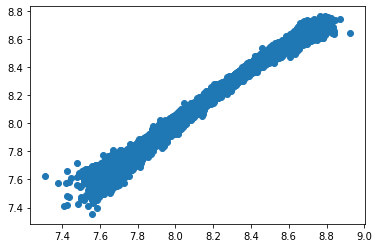

In [79]:
plt.scatter(stacked_lasso_oof, oof["NN"])